In [ ]:
# Imports
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import yfinance as yf
from fredapi import Fred
from scipy.optimize import minimize
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import requests
import warnings
from tqdm import tqdm
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
warnings.filterwarnings('ignore')
from scipy.stats import skew, kurtosis, norm

## Extracting prices from Yahoo Finance

In [ ]:
# Top 21 highest market cap - https://coinmarketcap.com/historical/20181003/

# Selecting tickers
tickers = [
    "BTC-USD",          # Bitcoin
    "XRP-USD",          # XRP
    "ETH-USD",          # Ethereum
    "BCH-USD",          # Bitcoin Cash
    "EOS-USD",          # EOS
    "XLM-USD",          # Stellar
    "LTC-USD",          # Litecoin
    "TRX-USD",          # TRON
    "ADA-USD",          # Cardano
    "IOTA-USD",         # IOTA
    "MIOTA-USD",        # IOTA
    "BNB-USD",          # Binance Coin
    "XMR-USD",          # Monero
    "DASH-USD",         # Dash
    "XEM-USD",          # NEM
    "ETC-USD",          # Ethereum Classic
    "NEO-USD",          # Neo
    "MKR-USD",          # Maker
    "WAVES-USD",        # Waves
    "ZEC-USD",          # Zcash
    "XTZ-USD"           # Tezos
]


# Verifying the number of tickers
len(tickers)

21

In [ ]:
rolling_window = 90
annualization_factor = 360

# Extracting adjusted close prices
year = input("Select one year (all, 2019, 2020, 2021, 2022 or 2023): ")

print(f"You've selected the year {year}.")
    
# Inicializar variáveis para restrições e limites
start_date = []
end_date = []

# All
if year == 'all':
    start_date = (datetime(2019, 1, 1).date() - timedelta(days=rolling_window)).strftime('%Y-%m-%d')
    end_date = '2024-01-01'

# 2019
elif year == '2019':
    start_date = (datetime(2019, 1, 1).date() - timedelta(days=rolling_window)).strftime('%Y-%m-%d')
    end_date = '2020-01-01'

# 2020
elif year == '2020':
    start_date = (datetime(2020, 1, 1).date() - timedelta(days=rolling_window)).strftime('%Y-%m-%d')
    end_date = '2021-01-01'

# 2021
elif year == '2021':
    start_date = (datetime(2021, 1, 1).date() - timedelta(days=rolling_window)).strftime('%Y-%m-%d')
    end_date = '2022-01-01'

# 2022
elif year == '2022':
    start_date = (datetime(2022, 1, 1).date() - timedelta(days=rolling_window)).strftime('%Y-%m-%d')
    end_date = '2023-01-01'

# 2023&2024
elif year == '2023':
    start_date = (datetime(2023, 1, 1).date() - timedelta(days=rolling_window)).strftime('%Y-%m-%d')
    end_date = '2024-01-01'

else:
    print('Invalid year. Try again.')
    start_date = None
    end_date = None

print(f"Start date: {start_date}")
print(f"End date: {end_date}")

You've selected the year all.
Start date: 2018-10-03
End date: 2024-01-01


In [37]:
prices = yf.download(tickers,
                     start = start_date,
                     end = end_date,
                     progress = False)['Adj Close']

prices.index = prices.index.tz_localize(None)
prices.head()

Ticker,ADA-USD,BCH-USD,BNB-USD,BTC-USD,DASH-USD,EOS-USD,ETC-USD,ETH-USD,IOTA-USD,LTC-USD,...,MKR-USD,NEO-USD,TRX-USD,WAVES-USD,XEM-USD,XLM-USD,XMR-USD,XRP-USD,XTZ-USD,ZEC-USD
Date,,,,,,,,,,,,,,,,,,,,,
2018-10-03,0.080789,514.525024,10.2712,6502.589844,177.559006,5.61811,11.1183,220.488998,NaN,57.477501,...,503.243988,17.9438,0.021600,2.13857,0.101770,0.241136,114.684998,0.528162,1.30780,122.060997
2018-10-04,0.081304,513.030029,10.2556,6576.689941,180.453995,5.77741,11.0469,222.218002,NaN,58.279499,...,530.859985,17.9086,0.022703,2.14249,0.103695,0.244278,114.533997,0.526606,1.30214,124.031998
2018-10-05,0.082991,520.632996,10.6362,6622.479980,182.050003,5.81133,11.0535,227.600998,NaN,58.766201,...,607.088013,18.1560,0.023275,2.19801,0.106169,0.245192,114.876999,0.519026,1.32074,127.724998
2018-10-06,0.081303,508.623993,10.3721,6588.310059,180.386993,5.72932,10.9180,225.119995,NaN,57.844101,...,636.080017,17.8787,0.023715,2.12498,0.103371,0.239771,115.070000,0.488082,1.33532,125.809998
2018-10-07,0.084658,517.468018,10.5190,6602.950195,180.251007,5.75912,10.8981,226.119003,NaN,58.160301,...,622.088989,18.0625,0.026875,2.12038,0.105833,0.245138,113.717003,0.482039,1.31746,125.459000


In [38]:
if 'MIOTA-USD' in prices.columns:
    prices['IOTA-USD'] = prices['IOTA-USD'].fillna(prices['MIOTA-USD'])
    prices = prices.drop('MIOTA-USD', axis=1)
    prices.head()

In [39]:
prices.isna().sum()

Ticker
ADA-USD      0
BCH-USD      0
BNB-USD      0
BTC-USD      0
DASH-USD     0
EOS-USD      0
ETC-USD      0
ETH-USD      0
IOTA-USD     0
LTC-USD      0
MKR-USD      0
NEO-USD      0
TRX-USD      0
WAVES-USD    0
XEM-USD      0
XLM-USD      0
XMR-USD      0
XRP-USD      0
XTZ-USD      0
ZEC-USD      0
dtype: int64

In [ ]:
# prices.to_csv('prices.csv')

In [41]:
tickers = list(prices.columns)

In [42]:
# Checking the DataFrame shape
prices.shape

(1916, 20)

In [ ]:
# Calculating the daily simple returns for each ticker
daily_simple_returns = prices.pct_change(1).dropna()
daily_simple_returns.head()

Ticker,ADA-USD,BCH-USD,BNB-USD,BTC-USD,DASH-USD,EOS-USD,ETC-USD,ETH-USD,IOTA-USD,LTC-USD,MKR-USD,NEO-USD,TRX-USD,WAVES-USD,XEM-USD,XLM-USD,XMR-USD,XRP-USD,XTZ-USD,ZEC-USD
Date,,,,,,,,,,,,,,,,,,,,
2018-10-04,0.006375,-0.002906,-0.001519,0.011395,0.016304,0.028355,-0.006422,0.007842,0.002990,0.013953,0.054876,-0.001962,0.051065,0.001833,0.018915,0.013030,-0.001317,-0.002946,-0.004328,0.016148
2018-10-05,0.020749,0.014820,0.037111,0.006962,0.008844,0.005871,0.000597,0.024224,0.035479,0.008351,0.143593,0.013815,0.025195,0.025914,0.023858,0.003742,0.002995,-0.014394,0.014284,0.029775
2018-10-06,-0.020340,-0.023066,-0.024830,-0.005160,-0.009135,-0.014112,-0.012259,-0.010901,-0.019197,-0.015691,0.047756,-0.015273,0.018904,-0.033226,-0.026354,-0.022109,0.001680,-0.059619,0.011039,-0.014993
2018-10-07,0.041265,0.017388,0.014163,0.002222,-0.000754,0.005201,-0.001823,0.004438,0.014697,0.005466,-0.021996,0.010280,0.133249,-0.002165,0.023817,0.022384,-0.011758,-0.012381,-0.013375,-0.002790
2018-10-08,0.023022,0.022237,-0.001179,0.007463,0.010552,0.026797,0.005212,0.013869,0.052187,0.021532,0.209687,0.021636,-0.010530,0.011050,0.029537,0.015791,0.004907,0.015999,0.031257,0.008298


In [44]:
# Calculating the covariance matrix using the daily log returns
cov_matrix = daily_simple_returns.cov() * 360
cov_matrix.head()

Ticker,ADA-USD,BCH-USD,BNB-USD,BTC-USD,DASH-USD,EOS-USD,ETC-USD,ETH-USD,IOTA-USD,LTC-USD,MKR-USD,NEO-USD,TRX-USD,WAVES-USD,XEM-USD,XLM-USD,XMR-USD,XRP-USD,XTZ-USD,ZEC-USD
Ticker,,,,,,,,,,,,,,,,,,,,
ADA-USD,1.000700,0.701613,0.572497,0.456337,0.639975,0.728496,0.683648,0.639762,0.713041,0.665522,0.614837,0.717480,0.585509,0.651882,0.651387,0.741386,0.553503,0.649612,0.688209,0.653806
BCH-USD,0.701613,1.141497,0.580181,0.519797,0.772715,0.855325,0.840744,0.683161,0.732214,0.775836,0.636063,0.784902,0.618102,0.660259,0.646876,0.672943,0.601300,0.644706,0.695165,0.745426
BNB-USD,0.572497,0.580181,0.883749,0.412220,0.587660,0.611185,0.566563,0.552451,0.585779,0.570259,0.554249,0.626924,0.501262,0.583914,0.540982,0.525074,0.514214,0.517726,0.595073,0.587664
BTC-USD,0.456337,0.519797,0.412220,0.445715,0.458730,0.487533,0.458749,0.471810,0.461024,0.482025,0.429678,0.498336,0.389684,0.430056,0.412760,0.422853,0.417033,0.406477,0.452854,0.459079
DASH-USD,0.639975,0.772715,0.587660,0.458730,1.069570,0.765455,0.799620,0.612717,0.707680,0.702122,0.587537,0.752704,0.574285,0.662350,0.608987,0.633185,0.628167,0.611351,0.684910,0.837227


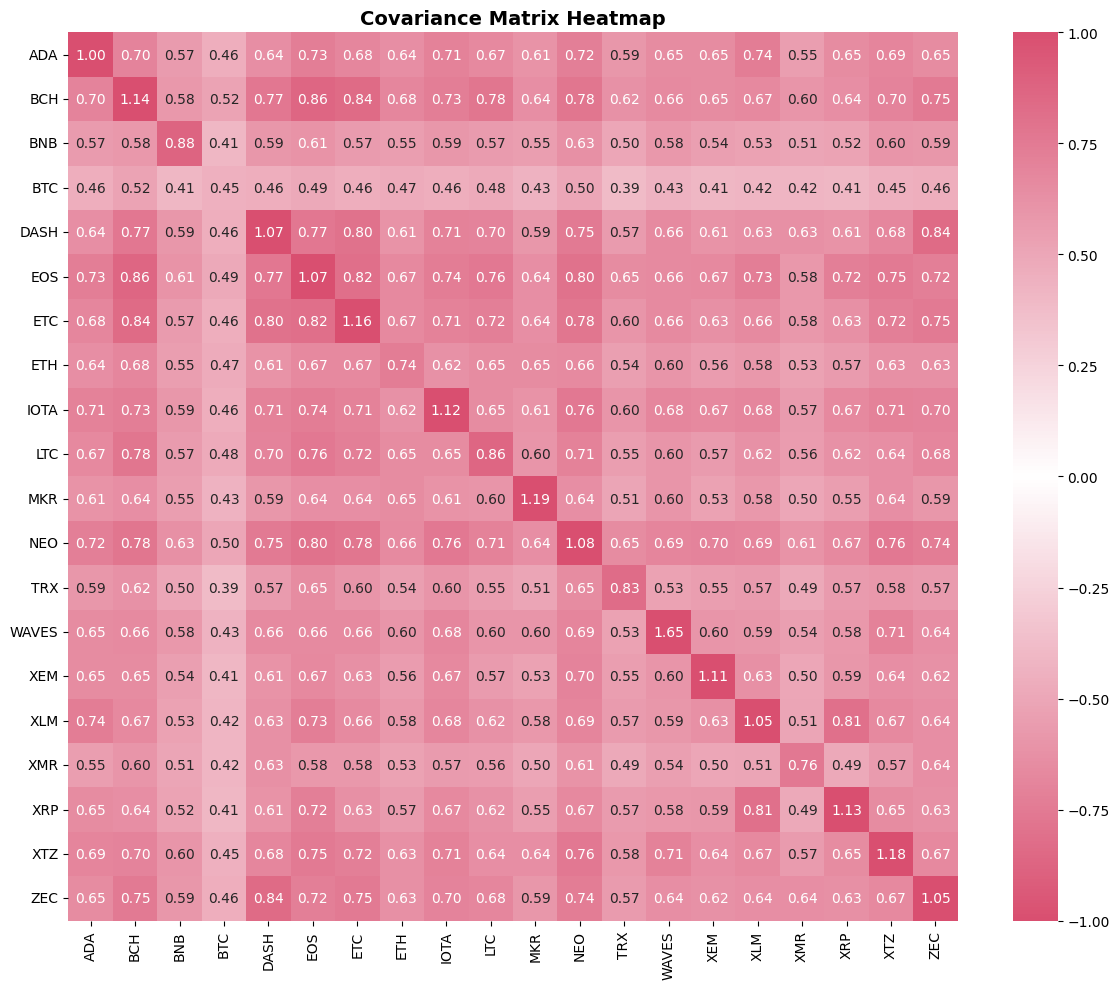

In [45]:
labels = [label[:-4] for label in cov_matrix.index]

# Ajustar o tamanho da figura
plt.figure(figsize=(12, 10))

# Definindo as cores
colors = ['#D94F70', 'white', '#D94F70']  # Degradê de cores

# Criar um mapa de cores personalizado
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)

# Criar o mapa de calor com ajustes
sns.heatmap(round(cov_matrix,2), annot=True, fmt=".2f", xticklabels=labels, yticklabels=labels,
            annot_kws={'size': 10}, cmap=cmap, vmin=-1, vmax=1, center=0)

plt.xlabel('')
plt.ylabel('')

# Exibir o gráfico
plt.title('Covariance Matrix Heatmap', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### Hypothesis Tests

In [46]:
# from scipy.stats import jarque_bera
# from mpmath import mp

# # Definir alta precisão
# mp.dps = 50  # Configurar 50 casas decimais para maior precisão

# # Aplicar o teste JB
# jb_stat, p_value = jarque_bera(daily_simple_returns["BTC-USD"].dropna())

# # Usar mpmath para exibir o p-valor com maior precisão
# p_value_high_precision = mp.mpf(p_value)

# print(f"JB Statistic: {jb_stat}")
# print(f"p-value (high precision): {p_value_high_precision}")

In [47]:
# # Teste Normal
# norm_params = stats.norm.fit(data)
# print(f"Parâmetros ajustados da normal: μ={norm_params[0]:.2f}, σ={norm_params[1]:.2f}")

# # Teste KS para a normal
# ks_stat_norm, p_value_norm = stats.kstest(data, "norm", args=norm_params)
# print(f"Estatística do teste KS para normal: {ks_stat_norm:.4f}, p-valor: {p_value_norm:.4f}")

# if p_value_norm > 0.05:
#     print("Não há evidência para rejeitar a hipótese de que os dados seguem uma distribuição normal.\n\n")
# else:
#     print("Os dados não seguem uma distribuição normal.\n\n")


# # Teste t
# t_params = stats.t.fit(data)
# df, loc, scale = t_params

# t_params = stats.t.fit(data)
# print(f"Parâmetros ajustados da distribuição t: ν={t_params[0]:.2f}, μ={t_params[1]:.2f}, σ={t_params[2]:.2f}")

# # Teste KS comparando os dados à distribuição t ajustada
# ks_stat, p_value = stats.kstest(data, "t", args=t_params)
# print(f"Estatística do teste KS: {ks_stat:.4f}, p-valor: {p_value:.4f}")

# if p_value > 0.05:
#     print("Não há evidência para rejeitar a hipótese de que os dados seguem uma distribuição t.")
# else:
#     print("Os dados não seguem uma distribuição t.")

In [48]:
# log_returns = np.log(prices / prices.shift(1))

In [49]:
# import pandas as pd
# import scipy.stats as stats

# # Criação de um DataFrame para armazenar os resultados
# results = []

# # Iterar por cada coluna do DataFrame
# for column in log_returns.columns:
#     data = log_returns[column].dropna()  # Remover valores NaN da coluna atual

#     # Ajustar a normal
#     norm_params = stats.norm.fit(data)
#     ks_stat_norm, p_value_norm = stats.kstest(data, "norm", args=norm_params)

#     # Ajustar a distribuição t
#     t_params = stats.t.fit(data)
#     ks_stat_t, p_value_t = stats.kstest(data, "t", args=t_params)

#     # Adicionar os resultados ao DataFrame
#     results.append({
#         "Asset": column,
#         "Normal_μ": norm_params[0],
#         "Normal_σ": norm_params[1],
#         "KS_Stat_Normal": ks_stat_norm,
#         "P_Value_Normal": p_value_norm,
#         "T_ν": t_params[0],
#         "T_μ": t_params[1],
#         "T_σ": t_params[2],
#         "KS_Stat_T": ks_stat_t,
#         "P_Value_T": p_value_t
#     })

# # Criar um DataFrame com os resultados
# results_df = pd.DataFrame(results)
# results_df = results_df.set_index("Asset")
# results_df

In [50]:
# from scipy.stats import shapiro

# # Aplicar o teste em todas as colunas de retornos
# shapiro_results = daily_simple_returns.apply(lambda x: shapiro(x.dropna()), axis=0)

# shapiro_results = shapiro_results.rename(index={0: 'Test Statistic', 1: 'p-value'}).T

# # Adicionar interpretação do resultado
# shapiro_results['normality'] = shapiro_results['p-value'].apply(
#     lambda p: 'Normal' if p > 0.05 else 'Not Normal')

# # Calculando a assimetria (skewness) de cada ativo
# skewness = daily_simple_returns.skew()
# kurtosis = daily_simple_returns.kurtosis()

# # Criando um DataFrame para exibir as estatísticas de skewness
# skewness_daily_simple_returns = pd.DataFrame({'Asset': skewness.index, 'Skewness': skewness.values})
# kurtosis_daily_simple_returns = pd.DataFrame({'Asset': kurtosis.index, 'Kurtosis': kurtosis.values})

# # Configurar o tamanho da figura geral
# plt.figure(figsize=(15, 20))

# # Encontrar o valor absoluto máximo em todas as colunas para centralizar 0
# max_abs_value = max(abs(daily_simple_returns.min().min()), abs(daily_simple_returns.max().max()))

# # Encontrar o valor máximo no eixo y para padronizar todos os gráficos
# max_y_value = 0

# # Determinar o valor máximo de frequência em todos os histogramas
# for column in daily_simple_returns.columns:
#     counts, _ = np.histogram(daily_simple_returns[column], bins=30)
#     max_y_value = max(max_y_value, counts.max())

# # Loop para criar um histograma por ativo
# for i, column in enumerate(daily_simple_returns.columns, 1):
#     plt.subplot(7,3, i)  # 5x4 grid para 20 ativos
#     plt.hist(daily_simple_returns[column], bins=30, alpha=0.7, edgecolor='k')
#     plt.title(column)  # Nome da coluna como título
#     plt.xlabel('Daily Log Return')
#     plt.ylabel('Frequency')
#     plt.xlim(-max_abs_value, max_abs_value)  # Definir os limites simétricos no eixo x
#     plt.ylim(0, max_y_value)  # Eixo y fixo para todos os gráficos
#     plt.text(
#         0.95, 0.95, 
#         f'Skewness: {skewness[column]:.5f}\nKurtosis: {kurtosis[column]:.5f}\n\nKolmogorov–Smirnov Test\np-value for Normality: {results_df.loc[column, 'P_Value_Normal']:.1e}\np-value for t-Student: {results_df.loc[column, 'P_Value_T']:.5f}\ndf for t-Student: {results_df.loc[column, 'T_ν']:.5f}', 
#         transform=plt.gca().transAxes, fontsize=8, ha='right', va='top',
#         bbox=dict(facecolor='white', alpha=0.7, edgecolor='black')
#     )

# plt.tight_layout()
# plt.show()

In [51]:
# import matplotlib.pyplot as plt
# from scipy.stats import probplot

# # Aplicar o estilo
# plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pacoty.mplstyle')

# # Configurar o layout para múltiplos gráficos
# num_assets = len(daily_simple_returns.columns)
# rows = (num_assets // 3)  # 4 colunas por linha

# fig, axes = plt.subplots(7, 3, figsize=(15, 20))  # Configurar subplots
# axes = axes.flatten()  # Transformar em uma lista para facilitar a iteração

# # Cor personalizada para as observações
# point_color = '#D94F70'  # Escolha uma cor

# # Gerar QQ-plots para cada ativo
# for i, column in enumerate(daily_simple_returns.columns):
#     res = probplot(daily_simple_returns[column].dropna(), dist="norm", plot=None)
#     axes[i].plot(res[0][0], res[1][0] * res[0][0] + res[1][1], color='black', lw=2, label='Normal Line')  # Linha
#     axes[i].scatter(res[0][0], res[0][1], color=point_color, label='Daily Returns')  # Observações
#     axes[i].set_title(f'{column}', fontsize=10)
#     axes[i].legend(fontsize=8)

# # Remover subplots vazios (caso o número de ativos não seja múltiplo de 4)
# for j in range(i + 1, len(axes)):
#     fig.delaxes(axes[j])

# # Ajustar o layout
# plt.tight_layout()
# plt.show()

## Defining functions

In [52]:
# Calculating the portfolio standard deviation
def variance(weights, cov_matrix):
    return weights.T @ cov_matrix @ weights

# Calculating the portfolio standard deviation
def standard_deviation(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)
## @ to multiply matrix

# Creating a function to calculate the expected return
def expected_return(weights, returns):
    return np.sum(returns.mean() * weights) * 360

# Creating a function to calculate the Sharpe Ratio
def sharpe_ratio(weights, returns, cov_matrix, risk_free_rate):
    return (expected_return(weights, returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)

# In the case of the scipy.optimize.minimize() function, there is no direct method to find the maximum value
def neg_sharpe_ratio(weights, returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, returns, cov_matrix, risk_free_rate)

# Function to calculate the turnover
def turnover(weights):
    turnover = weights.diff().abs().sum(axis=1) / 2
    return turnover

# Fucntion to evaluate portfolio concentration
def herfindahl_norm_index(weights):
    hhi = np.sum(weights**2)
    n = len(weights)
    return (hhi - 1 / n) / (1 - 1 / n)

# Function to calculate the Modified Sharpe Ratio
def modified_sharpe_ratio(weights, returns, risk_free_rate):
    portfolio_mean_return = returns.dot(weights).mean()
    excess_return = portfolio_mean_return - risk_free_rate
    modified_var1 = modified_var(weights, returns)
    msr = excess_return / modified_var1
    return msr

# Function to calculate the Negative Modified Sharpe Ratio
def neg_modified_sharpe_ratio(weights, returns, risk_free_rate):
    msr = modified_sharpe_ratio(weights, returns, risk_free_rate)
    return -msr

# Function to calculate the Modified VaR
def modified_var(weights, returns, confidence_level=0.95):
    portfolio_returns = returns.dot(weights)
    mean_return = portfolio_returns.mean()
    std_dev = portfolio_returns.std()
    skewness = skew(portfolio_returns)
    kurt = kurtosis(portfolio_returns, fisher=True)
    z_score = norm.ppf(1 - confidence_level)
    adjusted_z = z_score * (
        1 + (skewness / 6) * (z_score**2 - 1) + 
        (kurt / 24) * (z_score**3 - 3 * z_score) - 
        (skewness**2 / 36) * (2 * z_score**3 - 5 * z_score)
    )
    modified_var = mean_return - adjusted_z * std_dev
    return modified_var

# Function to calculate the Porfolios Modified VaR
def portfolio_modified_var(portfolio_returns, confidence_level=0.95):
    mean_return = portfolio_returns.mean()
    std_dev = portfolio_returns.std()
    skewness = skew(portfolio_returns)
    kurt = kurtosis(portfolio_returns, fisher=True)
    z_score = norm.ppf(1 - confidence_level)
    adjusted_z = z_score * (
        1 + (skewness / 6) * (z_score**2 - 1) + 
        (kurt / 24) * (z_score**3 - 3 * z_score) - 
        (skewness**2 / 36) * (2 * z_score**3 - 5 * z_score)
    )
    annual_mean = (1 + mean_return) ** annualization_factor - 1
    annual_std_dev = std_dev * np.sqrt(annualization_factor)
    modified_var_annualized = annual_mean - adjusted_z * annual_std_dev
    return -modified_var_annualized

# Function to calculate the Conditional Value at Risk
def conditional_value_at_risk(weights, returns, confidence_level=0.95):
    portfolio_returns = np.dot(returns, weights)
    sorted_returns = np.sort(portfolio_returns)
    var_index = int((1 - confidence_level) * len(sorted_returns))
    var_value = sorted_returns[var_index]
    losses_below_var = sorted_returns[sorted_returns <= var_value]
    cvar = float(abs(np.mean(losses_below_var)))
    return cvar

# Function to calculate the Portfolios Conditional Value at Risk
def calculate_cvar(portfolio_returns, confidence_level=0.95):
    cvars = {}
    for portfolio in portfolio_returns.columns:
        sorted_returns = np.sort(portfolio_returns[portfolio].dropna())
        var_index = int((1 - 0.95) * len(sorted_returns))
        var_value = sorted_returns[var_index]
        losses_below_var = sorted_returns[sorted_returns <= var_value]
        cvars[portfolio] = abs(np.mean(losses_below_var))
    return pd.DataFrame(cvars, index=['CVaR']).T

## Extracting risk free rate from Fred

In [53]:
# Replace 'your_api_key' with your actual FRED API key
fred = Fred(api_key = '1564e73fd4121b32615e55d0cce014f4')

In [54]:
# Get the 3-month Treasury rate
treasury_rate = fred.get_series('DGS3MO') / 100

# Convert the Treasury rate to a DataFrame
treasury_rate = pd.DataFrame(treasury_rate, columns=['Treasury Rate'])

In [55]:
# Create a new date range that includes all dates from daily_simple_returns
all_dates = pd.date_range(start=daily_simple_returns.index.min(), end=daily_simple_returns.index.max())

# Reindex treasury_rate to include all dates and forward fill missing values with the most recent data
treasury_rate = treasury_rate.reindex(all_dates)
treasury_rate['Treasury Rate'] = treasury_rate['Treasury Rate'].ffill()

In [56]:
# Diarizing the rates (they are annualized)
treasury_rate['Treasury Rate'] = ((1 + treasury_rate['Treasury Rate']) ** (1/360)) - 1

## Defining bonds and constraints

In [57]:
h_max = 0.2
bounds = None
constraints = [
    {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},
    {'type': 'ineq', 'fun': lambda weights: h_max - herfindahl_norm_index(weights)}
]

## F&G Index

In [58]:
# Building the URL
limit = "0"
format = "json"
date_format = "world"
url = f"https://api.alternative.me/fng/?limit={limit}&format={format}&date_format={date_format}"

In [59]:
# Request API: https://alternative.me/crypto/fear-and-greed-index/
r = requests.get(url).json()

In [60]:
# Extracting the data
data = r['data']

# Converting the data to a DataFrame
sentiment = pd.DataFrame(data)

In [61]:
# Filtering the data
sentiment = sentiment[['timestamp', 'value']]
sentiment.rename(columns={'timestamp': 'Date', 'value':'F&G'}, inplace=True)

# Transforming the data
sentiment['Date'] = pd.to_datetime(sentiment['Date'], format='%d-%m-%Y')
sentiment['F&G'] = pd.to_numeric(sentiment['F&G'])
sentiment = sentiment.sort_values(by='Date', ascending=True).reset_index(drop=True)

# Viewing the data
sentiment.head()

,Date,F&G
0,2018-02-01,30
1,2018-02-02,15
2,2018-02-03,40
3,2018-02-04,24
4,2018-02-05,11


In [62]:
# sentiment.to_excel('sentiment.xlsx', index=True)

In [63]:
# Inserting some missing dates with linear interpolation
if sentiment['Date'].loc[0] == pd.to_datetime('2018-02-01'):
    new_data = pd.DataFrame({'Date': pd.to_datetime(['2018-04-14', '2018-04-15', '2018-04-16']), 'F&G': np.nan})
    sentiment = pd.concat([sentiment, new_data])
    sentiment = sentiment.sort_values(by='Date')
    sentiment = sentiment.set_index('Date')
    sentiment['F&G'] = sentiment['F&G'].interpolate(method='linear')
    sentiment['F&G'] = sentiment['F&G'].astype(int)
else:
    sentiment = sentiment.set_index('Date')
    sentiment['F&G'] = sentiment['F&G'].astype(int)

In [64]:
# Filtering the sentiment dataframe
sentiment = sentiment[(sentiment.index <= end_date) & (sentiment.index >= start_date)]

### 95PCTL

In [65]:
# Copying the sentiment dataframe
sentiment_95PCTL = sentiment.copy()

In [66]:
# Calculating the 95th percentile
percentile_max = 0.95
sentiment_95PCTL['F&G_percentage_change'] = sentiment_95PCTL['F&G'].pct_change(1)
sentiment_95PCTL['F&G_percentage_change'] = sentiment_95PCTL['F&G_percentage_change'].dropna()
sentiment_95PCTL['F&G_upper_band'] = sentiment_95PCTL['F&G_percentage_change'].rolling(window=rolling_window).quantile(percentile_max)
sentiment_95PCTL['F&G_lower_band'] = sentiment_95PCTL['F&G_percentage_change'].rolling(window=rolling_window).quantile(1 - percentile_max)
sentiment_95PCTL.head(91)

,F&G,F&G_percentage_change,F&G_upper_band,F&G_lower_band
Date,,,,
2018-10-03,36,NaN,NaN,NaN
2018-10-04,29,-0.194444,NaN,NaN
2018-10-05,37,0.275862,NaN,NaN
2018-10-06,34,-0.081081,NaN,NaN
2018-10-07,29,-0.147059,NaN,NaN
...,...,...,...,...
2018-12-28,21,-0.275862,NaN,NaN
2018-12-29,24,0.142857,NaN,NaN
2018-12-30,23,-0.041667,NaN,NaN


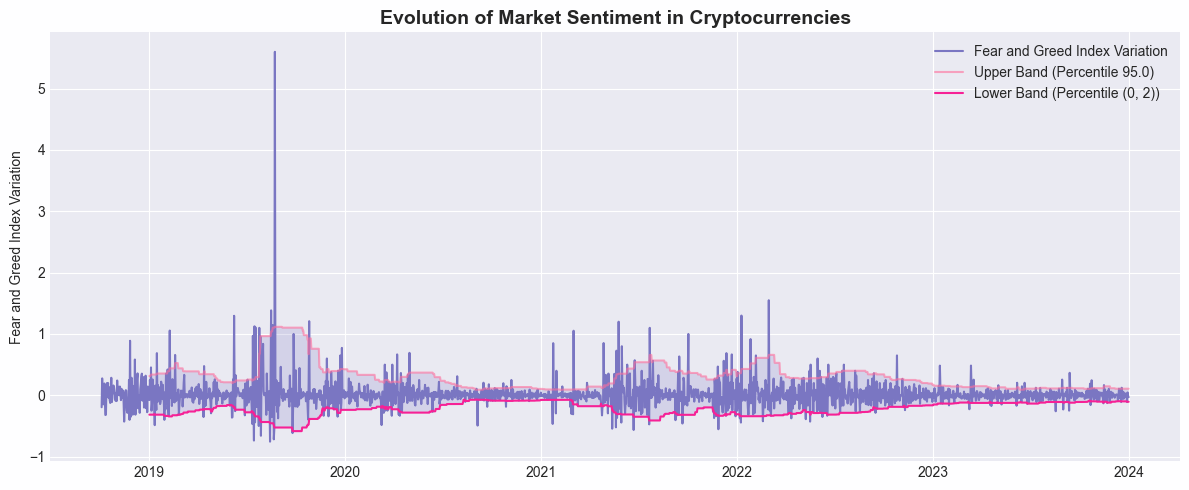

In [67]:
# Setting the style
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')

# Setting the size of the figure
plt.figure(figsize=(12, 5))

# Plotting the data
plt.plot(sentiment_95PCTL.index, sentiment_95PCTL['F&G_percentage_change'], label='Fear and Greed Index Variation')
plt.plot(sentiment_95PCTL.index, sentiment_95PCTL['F&G_upper_band'], label=f'Upper Band (Percentile {round(percentile_max * 100, 2)})')
plt.plot(sentiment_95PCTL.index, sentiment_95PCTL['F&G_lower_band'], label=f'Lower Band (Percentile {round(1 - percentile_max) * 100, 2})')

# Filling the area between the upper and lower bands
plt.fill_between(sentiment_95PCTL.index, sentiment_95PCTL['F&G_upper_band'], sentiment_95PCTL['F&G_lower_band'], alpha=0.2)

# Formatting the plot
plt.title('Evolution of Market Sentiment in Cryptocurrencies', fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.ylabel('Fear and Greed Index Variation')
plt.legend()
plt.tight_layout()

# Showing the plot
plt.show()

### 99PCTL

In [68]:
# Copying the sentiment dataframe
sentiment_99PCTL = sentiment.copy()

In [69]:
# Calculating the 99th percentile
percentile_max = 0.99
sentiment_99PCTL['F&G_percentage_change'] = sentiment_99PCTL['F&G'].pct_change(1)
sentiment_99PCTL['F&G_percentage_change'] = sentiment_99PCTL['F&G_percentage_change'].dropna()
sentiment_99PCTL['F&G_upper_band'] = sentiment_99PCTL['F&G_percentage_change'].rolling(window=rolling_window).quantile(percentile_max)
sentiment_99PCTL['F&G_lower_band'] = sentiment_99PCTL['F&G_percentage_change'].rolling(window=rolling_window).quantile(1 - percentile_max)
sentiment_99PCTL.tail()

,F&G,F&G_percentage_change,F&G_upper_band,F&G_lower_band
Date,,,,
2023-12-28,73,0.000000,0.194906,-0.133547
2023-12-29,65,-0.109589,0.194906,-0.133547
2023-12-30,68,0.046154,0.194906,-0.133547
2023-12-31,67,-0.014706,0.194906,-0.133547
2024-01-01,65,-0.029851,0.194906,-0.133547


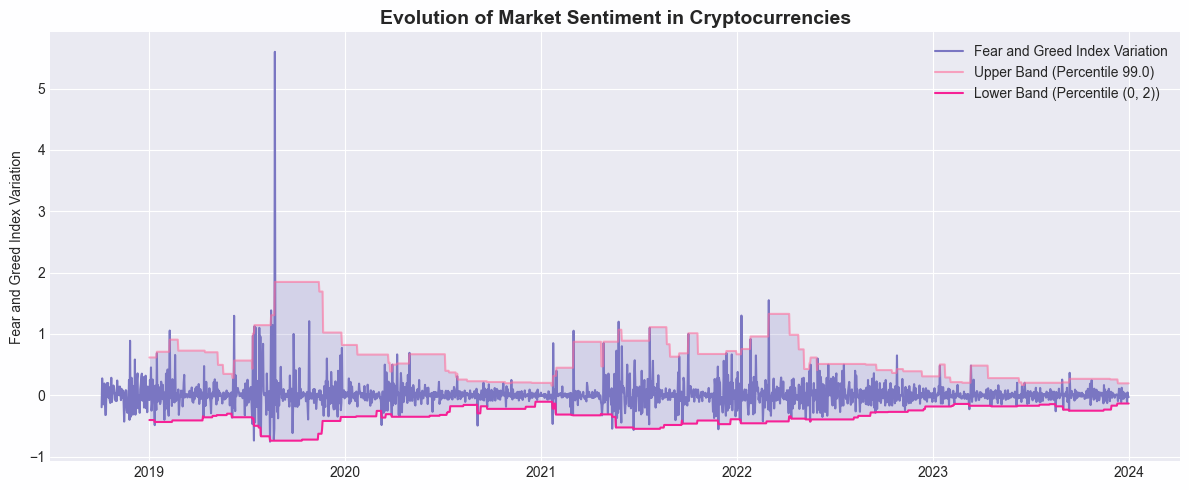

In [70]:
# Setting the style
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')

# Setting the size of the figure
plt.figure(figsize=(12, 5))

# Plotting the data
plt.plot(sentiment_99PCTL.index, sentiment_99PCTL['F&G_percentage_change'], label='Fear and Greed Index Variation')
plt.plot(sentiment_99PCTL.index, sentiment_99PCTL['F&G_upper_band'], label=f'Upper Band (Percentile {round(percentile_max * 100, 2)})')
plt.plot(sentiment_99PCTL.index, sentiment_99PCTL['F&G_lower_band'], label=f'Lower Band (Percentile {round(1 - percentile_max) * 100, 2})')

# Filling the area between the upper and lower bands
plt.fill_between(sentiment_99PCTL.index, sentiment_99PCTL['F&G_upper_band'], sentiment_99PCTL['F&G_lower_band'], alpha=0.2)

# Formatting the plot
plt.title('Evolution of Market Sentiment in Cryptocurrencies', fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.ylabel('Fear and Greed Index Variation')
plt.legend()
plt.tight_layout()

# Showing the plot
plt.show()

### 2STD

In [71]:
# Creating a copy os 'sentiment' DataFrame
sentiment_2STD = sentiment.copy()

# Calculating the moving average and standard deviation
sentiment_2STD['F&G_simple_moving_avg'] = sentiment_2STD['F&G'].rolling(window=rolling_window).mean()
sentiment_2STD['F&G_std'] = sentiment_2STD['F&G'].rolling(window=rolling_window).std()

# Calculating the upper and lower bands
sentiment_2STD['F&G_upper_band'] = sentiment_2STD['F&G_simple_moving_avg'] + 2 * sentiment_2STD['F&G_std']
sentiment_2STD['F&G_lower_band'] = sentiment_2STD['F&G_simple_moving_avg'] - 2 * sentiment_2STD['F&G_std']
sentiment_2STD.tail()

,F&G,F&G_simple_moving_avg,F&G_std,F&G_upper_band,F&G_lower_band
Date,,,,,
2023-12-28,73,64.522222,9.667771,83.857764,45.186681
2023-12-29,65,64.722222,9.485681,83.693585,45.750859
2023-12-30,68,64.944444,9.322392,83.589228,46.299661
2023-12-31,67,65.133333,9.187436,83.508206,46.758460
2024-01-01,65,65.300000,9.044770,83.389540,47.210460


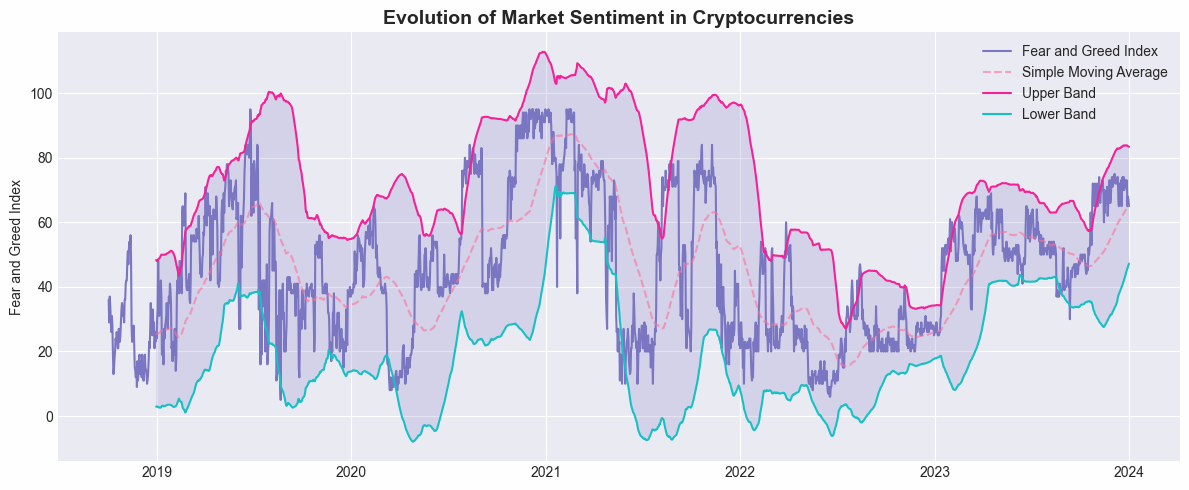

In [72]:
# Setting the style
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')

# Setting the size of the figure
plt.figure(figsize=(12, 5))

# Plotting the data
plt.plot(sentiment_2STD.index, sentiment_2STD['F&G'], label='Fear and Greed Index')
plt.plot(sentiment_2STD.index, sentiment_2STD['F&G_simple_moving_avg'], label='Simple Moving Average', linestyle='--')
plt.plot(sentiment_2STD.index, sentiment_2STD['F&G_upper_band'], label='Upper Band')
plt.plot(sentiment_2STD.index, sentiment_2STD['F&G_lower_band'], label='Lower Band')

# Filling the area between the upper and lower bands
plt.fill_between(sentiment_2STD.index, sentiment_2STD['F&G_upper_band'], sentiment_2STD['F&G_lower_band'], alpha=0.2)

# Formatting the plot
plt.title('Evolution of Market Sentiment in Cryptocurrencies', fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.ylabel('Fear and Greed Index')
plt.legend()
plt.tight_layout()

# Showing the plot
plt.show()

### 1STD

In [73]:
# Creating a copy os 'sentiment' DataFrame
sentiment_1STD = sentiment.copy()

# Calculating the moving average and standard deviation
sentiment_1STD['F&G_simple_moving_avg'] = sentiment_1STD['F&G'].rolling(window=rolling_window).mean()
sentiment_1STD['F&G_std'] = sentiment_1STD['F&G'].rolling(window=rolling_window).std()

# Calculating the upper and lower bands
sentiment_1STD['F&G_upper_band'] = sentiment_1STD['F&G_simple_moving_avg'] + 1 * sentiment_1STD['F&G_std']
sentiment_1STD['F&G_lower_band'] = sentiment_1STD['F&G_simple_moving_avg'] - 1 * sentiment_1STD['F&G_std']
sentiment_1STD.tail()

,F&G,F&G_simple_moving_avg,F&G_std,F&G_upper_band,F&G_lower_band
Date,,,,,
2023-12-28,73,64.522222,9.667771,74.189993,54.854451
2023-12-29,65,64.722222,9.485681,74.207904,55.236541
2023-12-30,68,64.944444,9.322392,74.266836,55.622053
2023-12-31,67,65.133333,9.187436,74.320770,55.945897
2024-01-01,65,65.300000,9.044770,74.344770,56.255230


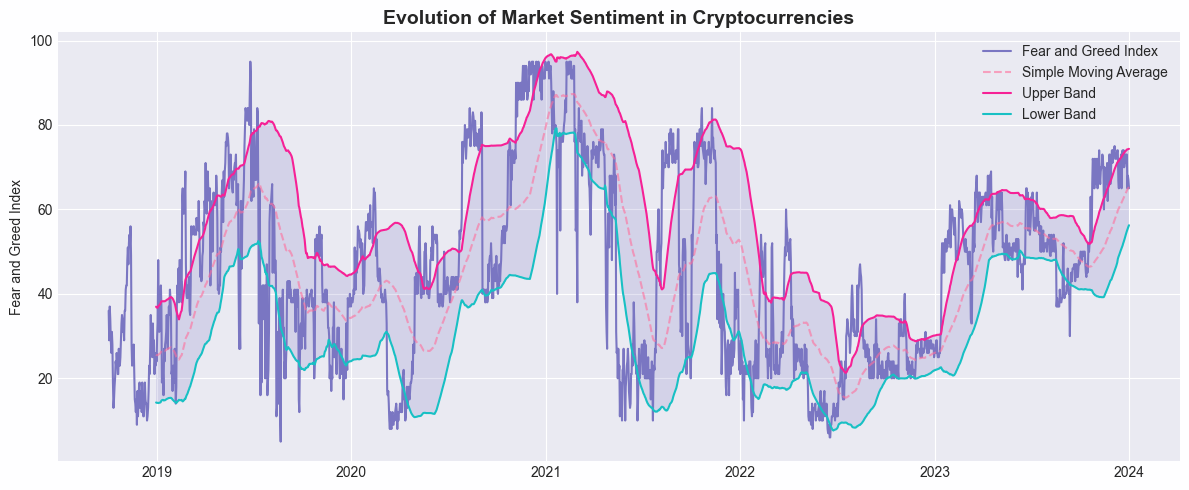

In [74]:
# Setting the style
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')

# Setting the size of the figure
plt.figure(figsize=(12, 5))

# Plotting the data
plt.plot(sentiment_1STD.index, sentiment_1STD['F&G'], label='Fear and Greed Index')
plt.plot(sentiment_1STD.index, sentiment_1STD['F&G_simple_moving_avg'], label='Simple Moving Average', linestyle='--')
plt.plot(sentiment_1STD.index, sentiment_1STD['F&G_upper_band'], label='Upper Band')
plt.plot(sentiment_1STD.index, sentiment_1STD['F&G_lower_band'], label='Lower Band')

# Filling the area between the upper and lower bands
plt.fill_between(sentiment_1STD.index, sentiment_1STD['F&G_upper_band'], sentiment_1STD['F&G_lower_band'], alpha=0.2)

# Formatting the plot
plt.title('Evolution of Market Sentiment in Cryptocurrencies', fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.ylabel('Fear and Greed Index')
plt.legend()
plt.tight_layout()

# Showing the plot
plt.show()

In [75]:
# graph1 = sentiment_95PCTL.copy()
# graph1 = graph1.merge(prices['BTC-USD'], how='inner', left_index=True, right_index=True)
# graph1['BTC-USD Return'] = graph1['BTC-USD'].pct_change(1)
# graph1 = graph1.dropna()
# graph1

### Evolution and Main Events Chart

In [76]:
# import matplotlib.pyplot as plt
# from datetime import datetime

# # Definir os momentos importantes (datas) para as linhas verticais
# important_dates = [
#     # datetime(2019, 6, 18),   # Anúncio do Libra (Facebook)
#     # datetime(2019, 7, 15),   # Audiências do Congresso dos EUA sobre criptomoedas
#     datetime(2020, 3, 12),   # "Quinta-feira Negra" (COVID-19)
#     # datetime(2020, 5, 11),   # Terceiro Halving do Bitcoin
#     # datetime(2020, 12, 17),  # Bitcoin ultrapassa seu ATH de 2017
#     # datetime(2021, 1, 8),    # Bitcoin ultrapassa US$40,000
#     datetime(2021, 2, 8),    # Tesla compra US$1.5 bilhão em Bitcoin
#     # datetime(2021, 9, 24),   # Queda acentuada após restrições da China
#     datetime(2021, 11, 10),  # ATH do Bitcoin (~US$69,000)
#     datetime(2022, 5, 9),    # Colapso da Terra (LUNA) e UST
#     # datetime(2022, 6, 18),   # Bitcoin cai abaixo de US$20,000
#     # datetime(2022, 11, 11),  # Falência da FTX
#     # datetime(2023, 1, 1),    # Início da recuperação no mercado
#     # datetime(2023, 6, 15),   # Primeiro ETF de Bitcoin Spot aprovado nos EUA
#     # datetime(2023, 10, 23)   # XRP vence parte do caso contra a SEC
# ]

# important_labels = [
#     # 'Libra Announcement',
#     # 'US Congress Hearings',
#     'COVID-19 Crash',
#     # 'Bitcoin Halving',
#     # 'ATH Surpass',
#     # 'Bitcoin > $40,000',
#     'Tesla Buys BTC',
#     # 'China Ban Crash',
#     'Bitcoin ATH',
#     'LUNA Collapse',
#     # 'Bitcoin <$20,000',
#     # 'FTX Collapse',
#     # 'Market Recovery',
#     # 'BTC ETF Approval',
#     # 'XRP vs SEC Victory'
# ]

# plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pacoty.mplstyle')

# # Configurar a figura com dois subplots
# fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), sharex=True)

# # Plotar o F&G absoluto no primeiro subplot
# axes[0].plot(graph1.index, graph1['F&G'], label='F&G Index', color='#D94F70')
# axes[0].set_ylabel('F&G Index')
# axes[0].legend(loc='upper left')

# for date, label in zip(important_dates, important_labels):
#     axes[0].axvline(x=date, color='gray', linestyle='--', linewidth=0.8)
# #     axes[0].text(date, axes[0].get_ylim()[1] * 0.95, label, rotation=90,
# #                  verticalalignment='top', horizontalalignment='right', fontsize=9, color='black',
# #                  bbox=dict(facecolor='white', alpha=0.8, edgecolor='black', boxstyle='round,pad=0.3'))

# # Plotar o preço ajustado do Bitcoin no segundo subplot
# axes[1].plot(graph1.index, graph1['BTC-USD'], label='Bitcoin Price (USD)', color='#009473')
# axes[1].set_ylabel('Bitcoin Price (USD)')
# axes[1].legend(loc='upper left')

# # Adicionar linhas verticais e rótulos no segundo gráfico
# for date, label in zip(important_dates, important_labels):
#     axes[1].axvline(x=date, color='gray', linestyle='--', linewidth=0.8)
#     axes[1].text(date, axes[1].get_ylim()[1] * 0.95, label, rotation=90,
#                  verticalalignment='top', horizontalalignment='right', fontsize=9, color='black',
#                  bbox=dict(facecolor='white', alpha=0.8, edgecolor='black', boxstyle='round,pad=0.3'))

# # Título geral do gráfico
# fig.suptitle('Time Evolution of the Crypto F&G index from October 2019 to December 2023', fontsize=14, fontweight='bold')

# # Ajustar layout
# plt.tight_layout()
# plt.show()

## Max. MSR Optimization

In [77]:
# Define the start date for the portfolio optimization
start_date = daily_simple_returns.index[0] + pd.DateOffset(days = rolling_window - 1)

# Initialize empty DataFrames to hold the portfolio returns, turnovers, volatilities, max sharpe ratios, and optimal weights
portfolio_returns = pd.DataFrame(index=daily_simple_returns.loc[start_date:].index)
turnover_df = pd.DataFrame(index=daily_simple_returns.loc[start_date:].index)
portfolio_volatility = pd.DataFrame(index=daily_simple_returns.loc[start_date:].index)
max_sharpe = pd.DataFrame(index=daily_simple_returns.loc[start_date:].index)
optimal_weights_df = pd.DataFrame(index=daily_simple_returns.loc[start_date:].index)

# Minimum period per optimization
minimum_optimization_periods = [7, 30, 90]
total_dates = len(daily_simple_returns.loc[start_date:].index)

### 95PCTL

In [ ]:
# DataFrame to store the daily weights
daily_weights_rolling_percentile95 = pd.DataFrame(index=daily_simple_returns.loc[start_date:].index, columns=tickers)

for period in minimum_optimization_periods:

    # Creating empty columns to store the portfolio returns, turnover, and volatility
    portfolio_returns[f'95PCTL {period} days'] = 0
    turnover_df[f'95PCTL {period} days'] = 0
    portfolio_volatility[f'95PCTL {period} days'] = 0
    optimal_weights_df[f'95PCTL {period} days'] = 0
    max_sharpe[f'95PCTL {period} days'] = 0

    # Set initial weights and last optimization date
    initial_weights = np.array([1/len(tickers)]*len(tickers))
    last_optimization_date = pd.Timestamp('1900-01-01')

    # Initialize an optimization counter
    optimization_count = 0
    
    with tqdm(total=total_dates, desc=f'Processing Period: {period} days') as pbar:
    
        for date, row in daily_simple_returns.loc[start_date:].iterrows():
            
            # Check if the date exists in the other DataFrames
            if date in treasury_rate.index:
                
                # Update the risk-free rate for the current date
                risk_free_rate = treasury_rate.loc[date - pd.Timedelta(days=1)]

                # Create a subset of the data from 1 year ago up to the current date
                subset = daily_simple_returns.loc[:date - pd.Timedelta(days=1)].last(f'{rolling_window}D')
                
                # Calculate the covariance matrix for the current subset
                cov_matrix = subset.cov()

                # Check if at least one week has passed since the last optimization
                if (date - last_optimization_date) >= pd.Timedelta(period, 'D'):
                    
                    # Check if the F&G Index has crossed the upper or the lower band
                    if (date == start_date) or (sentiment_95PCTL.loc[date - pd.Timedelta(days=1), 'F&G_percentage_change'] < sentiment_95PCTL.loc[date - pd.Timedelta(days=1), 'F&G_lower_band']) or (sentiment_95PCTL.loc[date - pd.Timedelta(days=1), 'F&G_percentage_change'] > sentiment_95PCTL.loc[date - pd.Timedelta(days=1), 'F&G_upper_band']):
                        
                        # print(date)
                        
                        # If yes, then optimization the portfolio...
                        optimized_results = minimize(neg_modified_sharpe_ratio,
                                                     initial_weights,
                                                     args=(subset, risk_free_rate),
                                                     method='SLSQP',
                                                     constraints=constraints,
                                                     bounds=bounds
                                                    )
                        optimal_weights = optimized_results.x
                        initial_weights = optimal_weights

                        # ...and update the optimization counter and the last optimization date
                        optimization_count += 1
                        last_optimization_date = date

                        optimal_weights_df[f'95PCTL {period} days'] = optimal_weights_df[f'95PCTL {period} days'].astype('object')
                        optimal_weights_df.at[date, f'95PCTL {period} days'] = optimal_weights.round(4).tolist()
                        
                        # Calculate the minimum variance for the current date
                        max_sharpe.loc[date, f'95PCTL {period} days'] = optimized_results['fun'] * (-1)
                # Register portfolio current weights
                daily_weights_rolling_percentile95.loc[date] = initial_weights

                # Calculate the portfolio return for the current date
                portfolio_returns.loc[date, f'95PCTL {period} days'] = np.dot(daily_simple_returns.loc[date], initial_weights)

                # Calculate the turnover
                turnover_ratio = turnover(daily_weights_rolling_percentile95).loc[date]
                turnover_df.loc[date, f'95PCTL {period} days'] = turnover_ratio

                # Calculate portfolio volatility
                portfolio_volatility.loc[date, f'95PCTL {period} days'] = standard_deviation(initial_weights, cov_matrix)

            pbar.update(1)

    print(f"95PCTL {period} days: {optimization_count} times.")

Processing Period: 7 days: 100%|██████████| 1826/1826 [03:43<00:00,  8.18it/s]


95PCTL 7 days: 94 times.


Processing Period: 30 days: 100%|██████████| 1826/1826 [02:22<00:00, 12.80it/s]


95PCTL 30 days: 44 times.


Processing Period: 90 days: 100%|██████████| 1826/1826 [01:26<00:00, 21.01it/s]

95PCTL 90 days: 18 times.


### 99PCTL

In [ ]:
# DataFrame to store the daily weights
daily_weights_rolling_percentile99 = pd.DataFrame(index=daily_simple_returns.loc[start_date:].index, columns=tickers)

for period in minimum_optimization_periods:

    # Creating empty columns to store the portfolio returns, turnover, and volatility
    portfolio_returns[f'99PCTL {period} days'] = 0
    turnover_df[f'99PCTL {period} days'] = 0
    portfolio_volatility[f'99PCTL {period} days'] = 0
    optimal_weights_df[f'99PCTL {period} days'] = 0
    max_sharpe[f'99PCTL {period} days'] = 0

    # Set initial weights and last optimization date
    initial_weights = np.array([1/len(tickers)]*len(tickers))
    last_optimization_date = pd.Timestamp('1900-01-01')

    # Initialize an optimization counter
    optimization_count = 0
    
    with tqdm(total=total_dates, desc=f'Processing Period: {period} days') as pbar:
    
        for date, row in daily_simple_returns.loc[start_date:].iterrows():
            
            # Check if the date exists in the other DataFrames
            if date in treasury_rate.index:
                
                # Update the risk-free rate for the current date
                risk_free_rate = treasury_rate.loc[date - pd.Timedelta(days=1)]

                # Create a subset of the data from 1 year ago up to the current date
                subset = daily_simple_returns.loc[:date - pd.Timedelta(days=1)].last(f'{rolling_window}D')
                
                # Calculate the covariance matrix for the current subset
                cov_matrix = subset.cov()

                # Check if at least one week has passed since the last optimization
                if (date - last_optimization_date) >= pd.Timedelta(period, 'D'):
                    
                    # Check if the F&G Index has crossed the upper or the lower band
                    if (date == start_date) or (sentiment_99PCTL.loc[date - pd.Timedelta(days=1), 'F&G_percentage_change'] < sentiment_99PCTL.loc[date - pd.Timedelta(days=1), 'F&G_lower_band']) or (sentiment_99PCTL.loc[date - pd.Timedelta(days=1), 'F&G_percentage_change'] > sentiment_99PCTL.loc[date - pd.Timedelta(days=1), 'F&G_upper_band']):
                        
                        # If yes, then optimization the portfolio...
                        optimized_results = minimize(neg_modified_sharpe_ratio,
                                                     initial_weights,
                                                     args=(subset, risk_free_rate),
                                                     method='SLSQP',
                                                     constraints=constraints,
                                                     bounds=bounds
                                                    )
                        optimal_weights = optimized_results.x
                        initial_weights = optimal_weights

                        # ...and update the optimization counter and the last optimization date
                        optimization_count += 1
                        last_optimization_date = date

                        optimal_weights_df[f'99PCTL {period} days'] = optimal_weights_df[f'99PCTL {period} days'].astype('object')
                        optimal_weights_df.at[date, f'99PCTL {period} days'] = optimal_weights.round(4).tolist()
                        
                        # Calculate the minimum variance for the current date
                        max_sharpe.loc[date, f'99PCTL {period} days'] = optimized_results['fun'] * (-1)
                # Register portfolio current weights
                daily_weights_rolling_percentile99.loc[date] = initial_weights

                # Calculate the portfolio return for the current date
                portfolio_returns.loc[date, f'99PCTL {period} days'] = np.dot(daily_simple_returns.loc[date], initial_weights)

                # Calculate the turnover
                turnover_ratio = turnover(daily_weights_rolling_percentile99).loc[date]
                turnover_df.loc[date, f'99PCTL {period} days'] = turnover_ratio

                # Calculate portfolio volatility
                portfolio_volatility.loc[date, f'99PCTL {period} days'] = standard_deviation(initial_weights, cov_matrix)

            pbar.update(1)

    print(f"99PCTL {period} days: {optimization_count} times.")

Processing Period: 7 days: 100%|██████████| 1826/1826 [02:15<00:00, 13.50it/s]


99PCTL 7 days: 29 times.


Processing Period: 30 days: 100%|██████████| 1826/1826 [02:05<00:00, 14.53it/s]


99PCTL 30 days: 21 times.


Processing Period: 90 days: 100%|██████████| 1826/1826 [02:05<00:00, 14.60it/s]

99PCTL 90 days: 12 times.


### 2STD

In [ ]:
# DataFrame to store the daily weights
daily_weights_SMA2 = pd.DataFrame(index=daily_simple_returns.loc[start_date:].index, columns=tickers)

for period in minimum_optimization_periods:

    # Creating empty columns to store the portfolio returns, turnover, and volatility
    portfolio_returns[f'2STD {period} days'] = 0
    turnover_df[f'2STD {period} days'] = 0
    portfolio_volatility[f'2STD {period} days'] = 0
    optimal_weights_df[f'2STD {period} days'] = 0
    max_sharpe[f'2STD {period} days'] = 0

    # Set initial weights and last optimization date
    initial_weights = np.array([1/len(tickers)]*len(tickers))
    last_optimization_date = pd.Timestamp('1900-01-01')

    # Initialize an optimization counter
    optimization_count = 0
    
    with tqdm(total=total_dates, desc=f'Processing Period: {period} days') as pbar:
    
        for date, row in daily_simple_returns.loc[start_date:].iterrows():
            
            # Check if the date exists in the other DataFrames
            if date in treasury_rate.index:
                
                # Update the risk-free rate for the current date
                risk_free_rate = treasury_rate.loc[date - pd.Timedelta(days=1)]

                # Create a subset of the data from 1 year ago up to the current date
                subset = daily_simple_returns.loc[:date - pd.Timedelta(days=1)].last(f'{rolling_window}D')
                
                # Calculate the covariance matrix for the current subset
                cov_matrix = subset.cov()

                # Check if at least one week has passed since the last optimization
                if (date - last_optimization_date) >= pd.Timedelta(period, 'D'):
                    
                    # Check if the F&G Index has crossed the upper or the lower band
                    if (date == start_date) or (sentiment_2STD.loc[date - pd.Timedelta(days=1), 'F&G'] < sentiment_2STD.loc[date - pd.Timedelta(days=1), 'F&G_lower_band']) or (sentiment_2STD.loc[date - pd.Timedelta(days=1), 'F&G'] > sentiment_2STD.loc[date - pd.Timedelta(days=1), 'F&G_upper_band']):
                        
                        # If yes, then optimization the portfolio...
                        optimized_results = minimize(neg_modified_sharpe_ratio,
                                                     initial_weights,
                                                     args=(subset, risk_free_rate),
                                                     method='SLSQP',
                                                     constraints=constraints,
                                                     bounds=bounds
                                                    )
                        optimal_weights = optimized_results.x
                        initial_weights = optimal_weights

                        # ...and update the optimization counter and the last optimization date
                        optimization_count += 1
                        last_optimization_date = date

                        optimal_weights_df[f'2STD {period} days'] = optimal_weights_df[f'2STD {period} days'].astype('object')
                        optimal_weights_df.at[date, f'2STD {period} days'] = optimal_weights.round(4).tolist()
                        
                        # Calculate the minimum variance for the current date
                        max_sharpe.loc[date, f'2STD {period} days'] = optimized_results['fun'] * (-1)
                # Register portfolio current weights
                daily_weights_SMA2.loc[date] = initial_weights

                # Calculate the portfolio return for the current date
                portfolio_returns.loc[date, f'2STD {period} days'] = np.dot(daily_simple_returns.loc[date], initial_weights)

                # Calculate the turnover
                turnover_ratio = turnover(daily_weights_SMA2).loc[date]
                turnover_df.loc[date, f'2STD {period} days'] = turnover_ratio

                # Calculate portfolio volatility
                portfolio_volatility.loc[date, f'2STD {period} days'] = standard_deviation(initial_weights, cov_matrix)

            pbar.update(1)

    print(f"2STD {period} days: {optimization_count} times.")

Processing Period: 7 days: 100%|██████████| 1826/1826 [02:25<00:00, 12.52it/s]


2STD 7 days: 50 times.


Processing Period: 30 days: 100%|██████████| 1826/1826 [02:58<00:00, 10.25it/s]


2STD 30 days: 22 times.


Processing Period: 90 days: 100%|██████████| 1826/1826 [02:13<00:00, 13.66it/s]

2STD 90 days: 14 times.


### 1STD

In [ ]:
# DataFrame to store the daily weights
daily_weights_SMA1 = pd.DataFrame(index=daily_simple_returns.loc[start_date:].index, columns=tickers)

for period in minimum_optimization_periods:

    # Creating empty columns to store the portfolio returns, turnover, and volatility
    portfolio_returns[f'1STD {period} days'] = 0
    turnover_df[f'1STD {period} days'] = 0
    portfolio_volatility[f'1STD {period} days'] = 0
    optimal_weights_df[f'1STD {period} days'] = 0
    max_sharpe[f'1STD {period} days'] = 0

    # Set initial weights and last optimization date
    initial_weights = np.array([1/len(tickers)]*len(tickers))
    last_optimization_date = pd.Timestamp('1900-01-01')

    # Initialize an optimization counter
    optimization_count = 0
    
    with tqdm(total=total_dates, desc=f'Processing Period: {period} days') as pbar:
    
        for date, row in daily_simple_returns.loc[start_date:].iterrows():
            
            # Check if the date exists in the other DataFrames
            if date in treasury_rate.index:
                
                # Update the risk-free rate for the current date
                risk_free_rate = treasury_rate.loc[date - pd.Timedelta(days=1)]

                # Create a subset of the data from 1 year ago up to the current date
                subset = daily_simple_returns.loc[:date - pd.Timedelta(days=1)].last(f'{rolling_window}D')
                
                # Calculate the covariance matrix for the current subset
                cov_matrix = subset.cov()

                # Check if at least one week has passed since the last optimization
                if (date - last_optimization_date) >= pd.Timedelta(period, 'D'):
                    
                    # Check if the F&G Index has crossed the upper or the lower band
                    if (date == start_date) or (sentiment_1STD.loc[date - pd.Timedelta(days=1), 'F&G'] < sentiment_1STD.loc[date - pd.Timedelta(days=1), 'F&G_lower_band']) or (sentiment_1STD.loc[date - pd.Timedelta(days=1), 'F&G'] > sentiment_1STD.loc[date - pd.Timedelta(days=1), 'F&G_upper_band']):
                        
                        # If yes, then optimization the portfolio...
                        optimized_results = minimize(neg_modified_sharpe_ratio,
                                                     initial_weights,
                                                     args=(subset, risk_free_rate),
                                                     method='SLSQP',
                                                     constraints=constraints,
                                                     bounds=bounds
                                                    )
                        optimal_weights = optimized_results.x
                        initial_weights = optimal_weights

                        # ...and update the optimization counter and the last optimization date
                        optimization_count += 1
                        last_optimization_date = date

                        optimal_weights_df[f'1STD {period} days'] = optimal_weights_df[f'1STD {period} days'].astype('object')
                        optimal_weights_df.at[date, f'1STD {period} days'] = optimal_weights.round(4).tolist()
                        
                        # Calculate the minimum variance for the current date
                        max_sharpe.loc[date, f'1STD {period} days'] = optimized_results['fun'] * (-1)
                # Register portfolio current weights
                daily_weights_SMA1.loc[date] = initial_weights

                # Calculate the portfolio return for the current date
                portfolio_returns.loc[date, f'1STD {period} days'] = np.dot(daily_simple_returns.loc[date], initial_weights)

                # Calculate the turnover
                turnover_ratio = turnover(daily_weights_SMA1).loc[date]
                turnover_df.loc[date, f'1STD {period} days'] = turnover_ratio

                # Calculate portfolio volatility
                portfolio_volatility.loc[date, f'1STD {period} days'] = standard_deviation(initial_weights, cov_matrix)

            pbar.update(1)

    print(f"1STD {period} days: {optimization_count} times.")

Processing Period: 7 days: 100%|██████████| 1826/1826 [05:08<00:00,  5.92it/s]


1STD 7 days: 165 times.


Processing Period: 30 days: 100%|██████████| 1826/1826 [00:56<00:00, 32.46it/s]


1STD 30 days: 51 times.


Processing Period: 90 days: 100%|██████████| 1826/1826 [00:49<00:00, 36.86it/s]

1STD 90 days: 19 times.


### FPO

In [ ]:
# List of optimization periods
minimum_optimization_periods = [7, 30, 90]

# DataFrame to store the daily weights
daily_weights_fixed = pd.DataFrame(index=daily_simple_returns.loc[start_date:].index, columns=tickers)

for period in minimum_optimization_periods:
    # Add a new column to hold the FPO returns
    portfolio_returns[f'FPO {period} days'] = 0
    turnover_df[f'FPO {period} days'] = 0
    portfolio_volatility[f'FPO {period} days'] = 0
    optimal_weights_df[f'FPO {period} days'] = 0
    max_sharpe[f'FPO {period} days'] = 0

    # Set initial weights and last optimization date
    initial_weights = np.array([1 / len(tickers)] * len(tickers))
    last_optimization_date = pd.Timestamp('1900-01-01')

    # Initialize an optimization counter
    optimization_count = 0
      
    with tqdm(total=total_dates, desc=f'Processing Period: {period} days') as pbar:
    
        for date, row in daily_simple_returns.loc[start_date:].iterrows():
            
            # Check if the date exists in the other DataFrames
            if date in treasury_rate.index:
                
                # Update the risk-free rate for the current date
                risk_free_rate = treasury_rate.loc[date - pd.Timedelta(days=1)]

                # Create a subset of the data from 1 year ago up to the current date
                subset = daily_simple_returns.loc[:date - pd.Timedelta(days=1)].last(f'{rolling_window}D')

                # Calculate the covariance matrix for the current subset
                cov_matrix = subset.cov()

                # Check if at least 'period' days have passed since the last FPO
                if ((date - last_optimization_date) >= pd.Timedelta(period, 'D')) or (date == start_date):
                    #print(date)
                    # If yes, then optimization the portfolio...
                    optimized_results_fixed = minimize(neg_modified_sharpe_ratio,
                                                     initial_weights,
                                                     args=(subset, risk_free_rate),
                                                     method='SLSQP',
                                                     constraints=constraints,
                                                     bounds=bounds
                                                    )
                    optimal_weights = optimized_results_fixed.x
                    initial_weights = optimal_weights

                    # ...and update the optimization counter and the last optimization date
                    optimization_count += 1
                    last_optimization_date = date

                    # Store the minimum variance for the current date
                    max_sharpe.loc[date, f'FPO {period} days'] = optimized_results_fixed['fun'] * (-1)
                    
                    # Store the optimal weights for the current date
                    optimal_weights_df[f'FPO {period} days'] = optimal_weights_df[f'FPO {period} days'].astype('object')
                    optimal_weights_df.at[date, f'FPO {period} days'] = optimal_weights.round(4).tolist()  

                # Register portfolio current weights
                daily_weights_fixed.loc[date] = initial_weights
                
                # Calculate the portfolio return for the current date
                portfolio_returns.loc[date, f'FPO {period} days'] = np.dot(daily_simple_returns.loc[date], initial_weights)

                # Calculate the turnover
                turnover_ratio = turnover(daily_weights_fixed).loc[date]
                turnover_df.loc[date, f'FPO {period} days'] = turnover_ratio

                # Calculate portfolio volatility
                portfolio_volatility.loc[date, f'FPO {period} days'] = standard_deviation(initial_weights, cov_matrix)
            
            pbar.update(1)

    print(f"FPO {period} days: {optimization_count} times.")

Processing Period: 7 days: 100%|██████████| 1826/1826 [02:42<00:00, 11.26it/s]


FPO 7 days: 261 times.


Processing Period: 30 days: 100%|██████████| 1826/1826 [00:54<00:00, 33.69it/s]


FPO 30 days: 61 times.


Processing Period: 90 days: 100%|██████████| 1826/1826 [00:44<00:00, 41.41it/s]

FPO 90 days: 21 times.


### Results Evaluation

In [83]:
# Calculating the cumulative returns
daily_cumulative_returns = (1 + portfolio_returns).cumprod()

In [84]:
# Annualizing the latest risk free rate
annualized_risk_free_fred = ((1 + treasury_rate.iloc[-1]) ** 360) - 1
print(annualized_risk_free_fred.values[0])

0.05400000000002736


In [85]:
# Extracting S&P 500 historical adjusted close price from Yahoo Finance
sp500_close = yf.download('^GSPC',
                          start=start_date.strftime('%Y-%m-%d'),
                          end=end_date,
                          progress = False)['Adj Close']

# Calculating daily log returns
sp500_returns = sp500_close.pct_change().dropna()

# Calculating the annualized standard deviation
annualized_std_sp500 = sp500_returns.std() * np.sqrt(360)
print(annualized_std_sp500)

Ticker
^GSPC    0.254863
dtype: float64


In [86]:
# Calculating EWMA daily variances (portfolio volatility)
lambda_value = 0.94
ewm_std_df = portfolio_returns.ewm(alpha = 1 - lambda_value, adjust = True).std()

In [87]:
# Parâmetros iniciais
transaction_cost_fee = 0.01
initial_value = 1000000
risk_free_rate = annualized_risk_free_fred.values[0]

In [88]:
# Parâmetros iniciais
transaction_cost_fee = 0.01
initial_value = 1000000
risk_free_rate = annualized_risk_free_fred.values[0]

# Cálculo das métricas antes dos custos de transação
maxmodsharpe_results = pd.DataFrame()
maxmodsharpe_results['Retorno Acumulado'] = daily_cumulative_returns.iloc[-1] - 1
maxmodsharpe_results['Retorno Anualizado'] = (maxmodsharpe_results['Retorno Acumulado'] + 1) ** (annualization_factor / len(daily_cumulative_returns)) - 1
maxmodsharpe_results['Mean Return'] = portfolio_returns.mean()
maxmodsharpe_results['Volatilidade Anualizada'] = portfolio_returns.std() * np.sqrt(annualization_factor)
maxmodsharpe_results['EWMA Anualizado'] = (portfolio_returns.ewm(alpha=1 - 0.94, adjust=False).std() * np.sqrt(annualization_factor)).mean()
maxmodsharpe_results['Skewness'] = skew(portfolio_returns)
maxmodsharpe_results['Kurtosis Anualizada'] = kurtosis(portfolio_returns, fisher=True)
maxmodsharpe_results['Maximum Drawdown'] = ((daily_cumulative_returns.cummax() - daily_cumulative_returns) / daily_cumulative_returns.cummax()).max()
maxmodsharpe_results['Modified VaR'] = portfolio_modified_var(portfolio_returns)
maxmodsharpe_results['Sharpe Ratio'] = (maxmodsharpe_results['Retorno Anualizado'] - risk_free_rate) / maxmodsharpe_results['EWMA Anualizado']
maxmodsharpe_results['Modified Sharpe Ratio'] = (maxmodsharpe_results['Retorno Anualizado'] - risk_free_rate) / (-maxmodsharpe_results['Modified VaR'])
maxmodsharpe_results['CVaR'] = calculate_cvar(portfolio_returns)

# Cálculo do turnover e custos de transação
maxmodsharpe_results['Turnover Diário Médio'] = turnover_df.mean()
maxmodsharpe_results['Turnover Total'] = turnover_df.sum()
maxmodsharpe_results['Transaction Cost'] = maxmodsharpe_results['Turnover Total'] * transaction_cost_fee
maxmodsharpe_results['Transaction Cost ($)'] = maxmodsharpe_results['Transaction Cost'] * initial_value

# Cálculo das métricas líquidas (depois dos custos de transação)
maxmodsharpe_results['Ending Portfolio Value'] = ((maxmodsharpe_results['Retorno Acumulado'] + 1) * initial_value)
maxmodsharpe_results['Ending Portfolio Value with Transaction Cost'] = maxmodsharpe_results['Ending Portfolio Value'] - maxmodsharpe_results['Transaction Cost ($)']
maxmodsharpe_results['Cumulative Return with Transaction Cost'] = (maxmodsharpe_results['Ending Portfolio Value with Transaction Cost'] / initial_value) - 1
maxmodsharpe_results['Annual Return with Transaction Cost'] = ((maxmodsharpe_results['Cumulative Return with Transaction Cost'] + 1) ** (annualization_factor / len(turnover_df))) - 1
maxmodsharpe_results['Sharpe Ratio with Transaction Cost'] = (maxmodsharpe_results['Annual Return with Transaction Cost'] - risk_free_rate) / maxmodsharpe_results['EWMA Anualizado']
maxmodsharpe_results['Modified Sharpe Ratio with Transaction Cost'] = (maxmodsharpe_results['Annual Return with Transaction Cost'] - risk_free_rate) / (-maxmodsharpe_results['Modified VaR'])

# Arredondamento dos valores para exibição
maxmodsharpe_results['Transaction Cost ($)'] = round(maxmodsharpe_results['Transaction Cost ($)'], 2)
maxmodsharpe_results['Ending Portfolio Value'] = round(maxmodsharpe_results['Ending Portfolio Value'], 2)
maxmodsharpe_results['Ending Portfolio Value with Transaction Cost'] = round(maxmodsharpe_results['Ending Portfolio Value with Transaction Cost'], 2)

maxmodsharpe_results = maxmodsharpe_results.T

In [89]:
daily_simple_returns_copy = daily_simple_returns.copy()

In [90]:
def adjust_index_to_date(df):
    # Converte o índice para DatetimeIndex, caso necessário
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)
    # Ajusta o índice para apenas a data, mantendo DatetimeIndex
    df.index = pd.to_datetime(df.index.date)
    return df

# dfs list
dfs = [turnover_df,
       max_sharpe,
       daily_simple_returns_copy,
       optimal_weights_df,
       portfolio_volatility,
       portfolio_returns,
       ewm_std_df]

# adjusting index
_ = [adjust_index_to_date(df) for df in dfs]

In [91]:
# Exporting the results to excel
with pd.ExcelWriter(f'C:\\Users\\maria\\OneDrive\\Documentos\\GitHub\\portfolio_management\\all_results\\{year}_maxmodsharpe_optimization_percentile_hhi{h_max}.xlsx') as writer:
    maxmodsharpe_results.to_excel(writer, sheet_name='Overall Results')
    max_sharpe.to_excel(writer, sheet_name='Sharpe Rate on Rebalancing')
    optimal_weights_df.to_excel(writer, sheet_name='Optimal Weights on Rebalancing')
    turnover_df.to_excel(writer, sheet_name='Daily Turnover')
    ewm_std_df.to_excel(writer, sheet_name='Daily Volatility (EWMA STD)')
    portfolio_returns.to_excel(writer, sheet_name='Daily Portfolio Returns')
    daily_simple_returns_copy.to_excel(writer, sheet_name='Daily Assets Returns')

## Min. CVaR Optimization

In [92]:
# Define the start date for the portfolio optimization
start_date = daily_simple_returns.index[0] + pd.DateOffset(days = rolling_window - 1)

# Initialize empty DataFrames to hold the portfolio returns, turnovers, volatility, minimum variance, and optimal weights
portfolio_returns = pd.DataFrame(index=daily_simple_returns.loc[start_date:].index)
turnover_df = pd.DataFrame(index=daily_simple_returns.loc[start_date:].index)
portfolio_volatility = pd.DataFrame(index=daily_simple_returns.loc[start_date:].index)
min_variance = pd.DataFrame(index=daily_simple_returns.loc[start_date:].index)
optimal_weights_df = pd.DataFrame(index=daily_simple_returns.loc[start_date:].index)

# Minimum period per optimization
minimum_optimization_periods = [7, 30, 90]
total_dates = len(daily_simple_returns.loc[start_date:].index)

### 95PCTL

In [93]:
# DataFrame to store the daily weights
daily_weights_rolling_percentile95 = pd.DataFrame(index=daily_simple_returns.loc[start_date:].index, columns=tickers)

for period in minimum_optimization_periods:

    # Initialize empty columns to hold the values
    portfolio_returns[f'95PCTL {period} days'] = 0
    turnover_df[f'95PCTL {period} days'] = 0
    portfolio_volatility[f'95PCTL {period} days'] = 0
    optimal_weights_df[f'95PCTL {period} days'] = 0
    min_variance[f'95PCTL {period} days'] = 0
    
    # Set initial weights and last optimization date
    initial_weights = np.array([1/len(tickers)]*len(tickers))
    last_optimization_date = pd.Timestamp('1900-01-01')

    # Initialize a optimization counter
    optimization_count = 0
    
    with tqdm(total=total_dates, desc=f'Processing Period: {period} days') as pbar:
    
        for date, row in daily_simple_returns.loc[start_date:].iterrows():
            
            # Check if the date exists in the other DataFrames
            if date in treasury_rate.index and date in sentiment_95PCTL.index:
                
                # Update the risk-free rate for the previous day
                risk_free_rate = treasury_rate.loc[date - pd.Timedelta(days=1)]

                # Create a subset of the data from 1 year ago up to the previous day (excluding current day)
                subset = daily_simple_returns.loc[:date - pd.Timedelta(days=1)].last(f'{rolling_window}D')

                # Calculate the covariance matrix for the current subset
                cov_matrix = subset.cov()

                # Check if at least one week has passed since the last optimization
                if (date - last_optimization_date) >= pd.Timedelta(period, 'D'):
                    
                    # Check if the F&G Index has crossed the upper or the lower band
                    if (date == start_date) or (sentiment_95PCTL.loc[date - pd.Timedelta(days=1), 'F&G_percentage_change'] < sentiment_95PCTL.loc[date - pd.Timedelta(days=1), 'F&G_lower_band']) or (sentiment_95PCTL.loc[date - pd.Timedelta(days=1), 'F&G_percentage_change'] > sentiment_95PCTL.loc[date - pd.Timedelta(days=1), 'F&G_upper_band']):
                        
                        # If yes, then optimization the portfolio...
                        optimized_results = minimize(conditional_value_at_risk,
                                                     initial_weights,
                                                     args=(subset),
                                                     method='SLSQP',
                                                     constraints=constraints
                                                    , bounds=bounds
                                                    )
                        optimal_weights = optimized_results.x
                        initial_weights = optimal_weights

                        # ...and update the optimization counter and the last optimization date
                        optimization_count += 1
                        last_optimization_date = date
                        
                        # Update the optimal weights DataFrame
                        optimal_weights_df[f'95PCTL {period} days'] = optimal_weights_df[f'95PCTL {period} days'].astype('object')
                        optimal_weights_df.at[date, f'95PCTL {period} days'] = optimal_weights.round(4).tolist()
                        
                        # Calculate the minimum variance for the current date
                        min_variance.loc[date, f'95PCTL {period} days'] = optimized_results['fun']
                
                # Calculate the portfolio return for the current date
                portfolio_returns.loc[date, f'95PCTL {period} days'] = np.dot(daily_simple_returns.loc[date], initial_weights)

                # Register portfolio current weights
                daily_weights_rolling_percentile95.loc[date] = initial_weights

                # Calculate the turnover
                turnover_ratio = turnover(daily_weights_rolling_percentile95).loc[date]
                turnover_df.loc[date, f'95PCTL {period} days'] = turnover_ratio

                # Calculate portfolio volatility
                portfolio_volatility.loc[date, f'95PCTL {period} days'] = standard_deviation(initial_weights, cov_matrix)

            pbar.update(1)

    print(f"95PCTL {period} days: {optimization_count} times.")

Processing Period: 7 days: 100%|██████████| 1826/1826 [00:42<00:00, 43.14it/s]


95PCTL 7 days: 94 times.


Processing Period: 30 days: 100%|██████████| 1826/1826 [00:48<00:00, 37.45it/s]


95PCTL 30 days: 44 times.


Processing Period: 90 days: 100%|██████████| 1826/1826 [01:02<00:00, 29.36it/s]

95PCTL 90 days: 18 times.


### 99PCTL

In [94]:
# DataFrame to store the daily weights
daily_weights_rolling_percentile99 = pd.DataFrame(index=daily_simple_returns.loc[start_date:].index, columns=tickers)

for period in minimum_optimization_periods:

    # Initialize empty columns to hold the values
    portfolio_returns[f'99PCTL {period} days'] = 0
    turnover_df[f'99PCTL {period} days'] = 0
    portfolio_volatility[f'99PCTL {period} days'] = 0
    optimal_weights_df[f'99PCTL {period} days'] = 0
    min_variance[f'99PCTL {period} days'] = 0
    
    # Set initial weights and last optimization date
    initial_weights = np.array([1/len(tickers)]*len(tickers))
    last_optimization_date = pd.Timestamp('1900-01-01')

    # Initialize a optimization counter
    optimization_count = 0
    
    with tqdm(total=total_dates, desc=f'Processing Period: {period} days') as pbar:
    
        for date, row in daily_simple_returns.loc[start_date:].iterrows():
            
            # Check if the date exists in the other DataFrames
            if date in treasury_rate.index and date in sentiment_99PCTL.index:
                
                # Update the risk-free rate for the previous day
                risk_free_rate = treasury_rate.loc[date - pd.Timedelta(days=1)]

                # Create a subset of the data from 1 year ago up to the previous day (excluding current day)
                subset = daily_simple_returns.loc[:date - pd.Timedelta(days=1)].last(f'{rolling_window}D')

                # Calculate the covariance matrix for the current subset
                cov_matrix = subset.cov()

                # Check if at least one week has passed since the last optimization
                if (date - last_optimization_date) >= pd.Timedelta(period, 'D'):
                    
                    # Check if the F&G Index has crossed the upper or the lower band
                    if (date == start_date) or (sentiment_99PCTL.loc[date - pd.Timedelta(days=1), 'F&G_percentage_change'] < sentiment_99PCTL.loc[date - pd.Timedelta(days=1), 'F&G_lower_band']) or (sentiment_99PCTL.loc[date - pd.Timedelta(days=1), 'F&G_percentage_change'] > sentiment_99PCTL.loc[date - pd.Timedelta(days=1), 'F&G_upper_band']):
                        
                        # If yes, then optimization the portfolio...
                        optimized_results = minimize(conditional_value_at_risk, initial_weights, args=(subset), method='SLSQP', constraints=constraints
                                                    , bounds=bounds
                                                    )
                        optimal_weights = optimized_results.x
                        initial_weights = optimal_weights

                        # ...and update the optimization counter and the last optimization date
                        optimization_count += 1
                        last_optimization_date = date
                        
                        # Update the optimal weights DataFrame
                        optimal_weights_df[f'99PCTL {period} days'] = optimal_weights_df[f'99PCTL {period} days'].astype('object')
                        optimal_weights_df.at[date, f'99PCTL {period} days'] = optimal_weights.round(4).tolist()
                        
                        # Calculate the minimum variance for the current date
                        min_variance.loc[date, f'99PCTL {period} days'] = optimized_results['fun']
                
                # Calculate the portfolio return for the current date
                portfolio_returns.loc[date, f'99PCTL {period} days'] = np.dot(daily_simple_returns.loc[date], initial_weights)

                # Register portfolio current weights
                daily_weights_rolling_percentile99.loc[date] = initial_weights

                # Calculate the turnover
                turnover_ratio = turnover(daily_weights_rolling_percentile99).loc[date]
                turnover_df.loc[date, f'99PCTL {period} days'] = turnover_ratio

                # Calculate portfolio volatility
                portfolio_volatility.loc[date, f'99PCTL {period} days'] = standard_deviation(initial_weights, cov_matrix)

            pbar.update(1)

    print(f"99PCTL {period} days: {optimization_count} times.")

Processing Period: 7 days: 100%|██████████| 1826/1826 [00:42<00:00, 43.17it/s]


99PCTL 7 days: 29 times.


Processing Period: 30 days: 100%|██████████| 1826/1826 [01:06<00:00, 27.52it/s]


99PCTL 30 days: 21 times.


Processing Period: 90 days: 100%|██████████| 1826/1826 [00:40<00:00, 45.16it/s]


99PCTL 90 days: 12 times.


### 2STD

In [95]:
# DataFrame to store the daily weights
daily_weights_SMA2 = pd.DataFrame(index=daily_simple_returns.loc[start_date:].index, columns=tickers)

for period in minimum_optimization_periods:

    # Initialize empty columns to hold the values
    portfolio_returns[f'2STD {period} days'] = 0
    turnover_df[f'2STD {period} days'] = 0
    portfolio_volatility[f'2STD {period} days'] = 0
    optimal_weights_df[f'2STD {period} days'] = 0
    min_variance[f'2STD {period} days'] = 0
    
    # Set initial weights and last optimization date
    initial_weights = np.array([1/len(tickers)]*len(tickers))
    last_optimization_date = pd.Timestamp('1900-01-01')

    # Initialize a optimization counter
    optimization_count = 0
    
    with tqdm(total=total_dates, desc=f'Processing Period: {period} days') as pbar:
    
        for date, row in daily_simple_returns.loc[start_date:].iterrows():
            
            # Check if the date exists in the other DataFrames
            if date in treasury_rate.index and date in sentiment_2STD.index:
                
                # Update the risk-free rate for the previous day
                risk_free_rate = treasury_rate.loc[date - pd.Timedelta(days=1)]

                # Create a subset of the data from 1 year ago up to the previous day (excluding current day)
                subset = daily_simple_returns.loc[:date - pd.Timedelta(days=1)].last(f'{rolling_window}D')

                # Calculate the covariance matrix for the current subset
                cov_matrix = subset.cov()

                # Check if at least one week has passed since the last optimization
                if (date - last_optimization_date) >= pd.Timedelta(period, 'D'):
                    
                    # Check if the F&G Index has crossed the upper or the lower band
                    if (date == start_date) or (sentiment_2STD.loc[date - pd.Timedelta(days=1), 'F&G'] < sentiment_2STD.loc[date - pd.Timedelta(days=1), 'F&G_lower_band']) or (sentiment_2STD.loc[date - pd.Timedelta(days=1), 'F&G'] > sentiment_2STD.loc[date - pd.Timedelta(days=1), 'F&G_upper_band']):
                        
                        # If yes, then optimization the portfolio...
                        optimized_results = minimize(conditional_value_at_risk, initial_weights, args=(subset), method='SLSQP', constraints=constraints
                                                    , bounds=bounds
                                                    )
                        optimal_weights = optimized_results.x
                        initial_weights = optimal_weights

                        # ...and update the optimization counter and the last optimization date
                        optimization_count += 1
                        last_optimization_date = date
                        
                        # Update the optimal weights DataFrame
                        optimal_weights_df[f'2STD {period} days'] = optimal_weights_df[f'2STD {period} days'].astype('object')
                        optimal_weights_df.at[date, f'2STD {period} days'] = optimal_weights.round(4).tolist()
                        
                        # Calculate the minimum variance for the current date
                        min_variance.loc[date, f'2STD {period} days'] = optimized_results['fun']
                
                # Calculate the portfolio return for the current date
                portfolio_returns.loc[date, f'2STD {period} days'] = np.dot(daily_simple_returns.loc[date], initial_weights)

                # Register portfolio current weights
                daily_weights_SMA2.loc[date] = initial_weights

                # Calculate the turnover
                turnover_ratio = turnover(daily_weights_SMA2).loc[date]
                turnover_df.loc[date, f'2STD {period} days'] = turnover_ratio

                # Calculate portfolio volatility
                portfolio_volatility.loc[date, f'2STD {period} days'] = standard_deviation(initial_weights, cov_matrix)

            pbar.update(1)

    print(f"2STD {period} days: {optimization_count} times.")

Processing Period: 7 days: 100%|██████████| 1826/1826 [00:49<00:00, 36.57it/s]


2STD 7 days: 50 times.


Processing Period: 30 days: 100%|██████████| 1826/1826 [00:44<00:00, 40.79it/s]


2STD 30 days: 22 times.


Processing Period: 90 days: 100%|██████████| 1826/1826 [00:40<00:00, 45.28it/s]

2STD 90 days: 14 times.


### 1STD

In [96]:
# DataFrame to store the daily weights
daily_weights_SMA1 = pd.DataFrame(index=daily_simple_returns.loc[start_date:].index, columns=tickers)

for period in minimum_optimization_periods:

    # Initialize empty columns to hold the values
    portfolio_returns[f'1STD {period} days'] = 0
    turnover_df[f'1STD {period} days'] = 0
    portfolio_volatility[f'1STD {period} days'] = 0
    optimal_weights_df[f'1STD {period} days'] = 0
    min_variance[f'1STD {period} days'] = 0
    
    # Set initial weights and last optimization date
    initial_weights = np.array([1/len(tickers)]*len(tickers))
    last_optimization_date = pd.Timestamp('1900-01-01')

    # Initialize a optimization counter
    optimization_count = 0
    
    with tqdm(total=total_dates, desc=f'Processing Period: {period} days') as pbar:
    
        for date, row in daily_simple_returns.loc[start_date:].iterrows():
            
            # Check if the date exists in the other DataFrames
            if date in treasury_rate.index and date in sentiment_1STD.index:
                
                # Update the risk-free rate for the previous day
                risk_free_rate = treasury_rate.loc[date - pd.Timedelta(days=1)]

                # Create a subset of the data from 1 year ago up to the previous day (excluding current day)
                subset = daily_simple_returns.loc[:date - pd.Timedelta(days=1)].last(f'{rolling_window}D')

                # Calculate the covariance matrix for the current subset
                cov_matrix = subset.cov()

                # Check if at least one week has passed since the last optimization
                if (date - last_optimization_date) >= pd.Timedelta(period, 'D'):
                    
                    # Check if the F&G Index has crossed the upper or the lower band
                    if (date == start_date) or (sentiment_1STD.loc[date - pd.Timedelta(days=1), 'F&G'] < sentiment_1STD.loc[date - pd.Timedelta(days=1), 'F&G_lower_band']) or (sentiment_1STD.loc[date - pd.Timedelta(days=1), 'F&G'] > sentiment_1STD.loc[date - pd.Timedelta(days=1), 'F&G_upper_band']):
                        
                        # If yes, then optimization the portfolio...
                        optimized_results = minimize(conditional_value_at_risk, initial_weights, args=(subset), method='SLSQP', constraints=constraints
                                                    , bounds=bounds
                                                    )
                        optimal_weights = optimized_results.x
                        initial_weights = optimal_weights

                        # ...and update the optimization counter and the last optimization date
                        optimization_count += 1
                        last_optimization_date = date
                        
                        # Update the optimal weights DataFrame
                        optimal_weights_df[f'1STD {period} days'] = optimal_weights_df[f'1STD {period} days'].astype('object')
                        optimal_weights_df.at[date, f'1STD {period} days'] = optimal_weights.round(4).tolist()
                        
                        # Calculate the minimum variance for the current date
                        min_variance.loc[date, f'1STD {period} days'] = optimized_results['fun']
                
                # Calculate the portfolio return for the current date
                portfolio_returns.loc[date, f'1STD {period} days'] = np.dot(daily_simple_returns.loc[date], initial_weights)

                # Register portfolio current weights
                daily_weights_SMA1.loc[date] = initial_weights

                # Calculate the turnover
                turnover_ratio = turnover(daily_weights_SMA1).loc[date]
                turnover_df.loc[date, f'1STD {period} days'] = turnover_ratio

                # Calculate portfolio volatility
                portfolio_volatility.loc[date, f'1STD {period} days'] = standard_deviation(initial_weights, cov_matrix)

            pbar.update(1)

    print(f"1STD {period} days: {optimization_count} times.")

Processing Period: 7 days: 100%|██████████| 1826/1826 [01:10<00:00, 25.93it/s]


1STD 7 days: 165 times.


Processing Period: 30 days: 100%|██████████| 1826/1826 [01:10<00:00, 26.04it/s]


1STD 30 days: 51 times.


Processing Period: 90 days: 100%|██████████| 1826/1826 [00:37<00:00, 49.18it/s]

1STD 90 days: 19 times.


### FPO

In [97]:
# DataFrame to store the daily weights
daily_weights = pd.DataFrame(index=daily_simple_returns.loc[start_date:].index, columns=tickers)

for period in minimum_optimization_periods:

    # Initialize empty columns to hold the values
    portfolio_returns[f'FPO {period} days'] = 0
    turnover_df[f'FPO {period} days'] = 0
    portfolio_volatility[f'FPO {period} days'] = 0
    optimal_weights_df[f'FPO {period} days'] = 0
    min_variance[f'FPO {period} days'] = 0
    
    # Set initial weights and last optimization date
    initial_weights = np.array([1/len(tickers)]*len(tickers))
    last_optimization_date = pd.Timestamp('1900-01-01')

    # Initialize a optimization counter
    optimization_count = 0
    
    with tqdm(total=total_dates, desc=f'Processing Period: {period} days') as pbar:
    
        for date, row in daily_simple_returns.loc[start_date:].iterrows():
            
            # Check if the date exists in the other DataFrames
            if date in treasury_rate.index and date in sentiment_1STD.index:
                
                # Update the risk-free rate for the previous day
                risk_free_rate = treasury_rate.loc[date - pd.Timedelta(days=1)]

                # Create a subset of the data from 1 year ago up to the previous day (excluding current day)
                subset = daily_simple_returns.loc[:date - pd.Timedelta(days=1)].last(f'{rolling_window}D')

                # Calculate the covariance matrix for the current subset
                cov_matrix = subset.cov()

                # Check if at least one week has passed since the last optimization
                if ((date - last_optimization_date) >= pd.Timedelta(period, 'D')) or (date == start_date):
                        
                    # If yes, then optimization the portfolio...
                    optimized_results = minimize(conditional_value_at_risk,
                                                 initial_weights,
                                                 args=(subset), method='SLSQP', constraints=constraints
                                                , bounds=bounds
                                                )
                    optimal_weights = optimized_results.x
                    initial_weights = optimal_weights

                    # ...and update the optimization counter and the last optimization date
                    optimization_count += 1
                    last_optimization_date = date
                    
                    # Update the optimal weights DataFrame
                    optimal_weights_df[f'FPO {period} days'] = optimal_weights_df[f'FPO {period} days'].astype('object')
                    optimal_weights_df.at[date, f'FPO {period} days'] = optimal_weights.round(4).tolist()
                    
                    # Calculate the minimum variance for the current date
                    min_variance.loc[date, f'FPO {period} days'] = optimized_results['fun']
                
                # Calculate the portfolio return for the current date
                portfolio_returns.loc[date, f'FPO {period} days'] = np.dot(daily_simple_returns.loc[date], initial_weights)

                # Register portfolio current weights
                daily_weights.loc[date] = initial_weights

                # Calculate the turnover
                turnover_ratio = turnover(daily_weights).loc[date]
                turnover_df.loc[date, f'FPO {period} days'] = turnover_ratio

                # Calculate portfolio volatility
                portfolio_volatility.loc[date, f'FPO {period} days'] = standard_deviation(initial_weights, cov_matrix)

            pbar.update(1)

    print(f"FPO {period} days: {optimization_count} times.")

Processing Period: 7 days: 100%|██████████| 1826/1826 [01:16<00:00, 23.76it/s]


FPO 7 days: 261 times.


Processing Period: 30 days: 100%|██████████| 1826/1826 [00:43<00:00, 41.78it/s]


FPO 30 days: 61 times.


Processing Period: 90 days: 100%|██████████| 1826/1826 [00:35<00:00, 50.87it/s]

FPO 90 days: 21 times.


### Results Evaluation

In [98]:
# Calculating the cumulative returns
daily_cumulative_returns = (1 + portfolio_returns).cumprod()

In [99]:
# Annualizing the latest risk free rate
annualized_risk_free_fred = ((1 + treasury_rate.iloc[-1]) ** 360) - 1
annualized_risk_free_fred.values[0]

np.float64(0.05400000000002736)

In [100]:
# Extracting S&P 500 historical adjusted close price from Yahoo Finance
sp500_close = yf.download('^GSPC',
                          start=start_date.strftime('%Y-%m-%d'),
                          end=end_date,
                          progress = False)['Adj Close']

# Calculating daily log returns
sp500_returns = sp500_close.pct_change().dropna()

# Calculating the annualized standard deviation
annualized_std_sp500 = sp500_returns.std() * np.sqrt(360)
print(annualized_std_sp500)

Ticker
^GSPC    0.254863
dtype: float64


In [101]:
# Calculating EWMA daily variances (portfolio volatility)
lambda_value = 0.94
ewm_std_df = portfolio_returns.ewm(alpha = 1 - lambda_value, adjust = True).std()

In [102]:
# Parâmetros iniciais
transaction_cost_fee = 0.01
initial_value = 1000000
risk_free_rate = annualized_risk_free_fred.values[0]

# Cálculo das métricas antes dos custos de transação
mincvar_results = pd.DataFrame()
mincvar_results['Retorno Acumulado'] = daily_cumulative_returns.iloc[-1] - 1
mincvar_results['Retorno Anualizado'] = (mincvar_results['Retorno Acumulado'] + 1) ** (annualization_factor / len(daily_cumulative_returns)) - 1
mincvar_results['Mean Return'] = portfolio_returns.mean()
mincvar_results['Volatilidade Anualizada'] = portfolio_returns.std() * np.sqrt(annualization_factor)
mincvar_results['EWMA Anualizado'] = (portfolio_returns.ewm(alpha=1 - 0.94, adjust=False).std() * np.sqrt(annualization_factor)).mean()
mincvar_results['Skewness'] = skew(portfolio_returns)
mincvar_results['Kurtosis Anualizada'] = kurtosis(portfolio_returns, fisher=True)
mincvar_results['Maximum Drawdown'] = ((daily_cumulative_returns.cummax() - daily_cumulative_returns) / daily_cumulative_returns.cummax()).max()
mincvar_results['Modified VaR'] = portfolio_modified_var(portfolio_returns)
mincvar_results['Sharpe Ratio'] = (mincvar_results['Retorno Anualizado'] - risk_free_rate) / mincvar_results['EWMA Anualizado']
mincvar_results['Modified Sharpe Ratio'] = (mincvar_results['Retorno Anualizado'] - risk_free_rate) / (-mincvar_results['Modified VaR'])
mincvar_results['CVaR'] = calculate_cvar(portfolio_returns)

# Cálculo do turnover e custos de transação
mincvar_results['Turnover Diário Médio'] = turnover_df.mean()
mincvar_results['Turnover Total'] = turnover_df.sum()
mincvar_results['Transaction Cost'] = mincvar_results['Turnover Total'] * transaction_cost_fee
mincvar_results['Transaction Cost ($)'] = mincvar_results['Transaction Cost'] * initial_value

# Cálculo das métricas líquidas (depois dos custos de transação)
mincvar_results['Ending Portfolio Value'] = ((mincvar_results['Retorno Acumulado'] + 1) * initial_value)
mincvar_results['Ending Portfolio Value with Transaction Cost'] = mincvar_results['Ending Portfolio Value'] - mincvar_results['Transaction Cost ($)']
mincvar_results['Cumulative Return with Transaction Cost'] = (mincvar_results['Ending Portfolio Value with Transaction Cost'] / initial_value) - 1
mincvar_results['Annual Return with Transaction Cost'] = ((mincvar_results['Cumulative Return with Transaction Cost'] + 1) ** (annualization_factor / len(turnover_df))) - 1
mincvar_results['Sharpe Ratio with Transaction Cost'] = (mincvar_results['Annual Return with Transaction Cost'] - risk_free_rate) / mincvar_results['EWMA Anualizado']
mincvar_results['Modified Sharpe Ratio with Transaction Cost'] = (mincvar_results['Annual Return with Transaction Cost'] - risk_free_rate) / (-mincvar_results['Modified VaR'])

# Arredondamento dos valores para exibição
mincvar_results['Transaction Cost ($)'] = round(mincvar_results['Transaction Cost ($)'], 2)
mincvar_results['Ending Portfolio Value'] = round(mincvar_results['Ending Portfolio Value'], 2)
mincvar_results['Ending Portfolio Value with Transaction Cost'] = round(mincvar_results['Ending Portfolio Value with Transaction Cost'], 2)

mincvar_results = mincvar_results.T  # Transforma o DataFrame para melhor visualização

In [103]:
def adjust_index_to_date(df):
    df.index = df.index.date
    return df

# dfs list
dfs = [turnover_df,
       min_variance,
       optimal_weights_df,
       portfolio_volatility,
       portfolio_returns,
       ewm_std_df]

# adjusting index
_ = [adjust_index_to_date(df) for df in dfs]

In [104]:
daily_simple_returns_copy = daily_simple_returns.copy()

In [105]:
daily_simple_returns_copy = daily_simple_returns.copy()

# Exporting the results to excel
with pd.ExcelWriter(f'C:\\Users\\maria\\OneDrive\\Documentos\\GitHub\\portfolio_management\\all_results\\{year}_mincvar_optimization_percentile_hhi{h_max}.xlsx') as writer:
    mincvar_results.to_excel(writer, sheet_name='Overall Results')
    min_variance.to_excel(writer, sheet_name='Minimum Variance on Rebalancing')
    optimal_weights_df.to_excel(writer, sheet_name='Optimal Weights on Rebalancing')
    turnover_df.to_excel(writer, sheet_name='Daily Turnover')
    ewm_std_df.to_excel(writer, sheet_name='Daily Volatility (EWMA STD)')
    portfolio_returns.to_excel(writer, sheet_name='Daily Portfolio Returns')
    daily_simple_returns_copy.to_excel(writer, sheet_name='Daily Assets Returns')

## Max. SR Optimization

In [106]:
# Define the start date for the portfolio optimization
start_date = daily_simple_returns.index[0] + pd.DateOffset(days = rolling_window - 1)

# Initialize empty DataFrames to hold the portfolio returns, turnovers, volatility, minimum variance, and optimal weights
portfolio_returns = pd.DataFrame(index=daily_simple_returns.loc[start_date:].index)
turnover_df = pd.DataFrame(index=daily_simple_returns.loc[start_date:].index)
portfolio_volatility = pd.DataFrame(index=daily_simple_returns.loc[start_date:].index)
min_variance = pd.DataFrame(index=daily_simple_returns.loc[start_date:].index)
optimal_weights_df = pd.DataFrame(index=daily_simple_returns.loc[start_date:].index)

# Minimum period per optimization
minimum_optimization_periods = [7, 30, 90]
total_dates = len(daily_simple_returns.loc[start_date:].index)

### 95PCTL

In [107]:
# DataFrame to store the daily weights
daily_weights_rolling_percentile95 = pd.DataFrame(index=daily_simple_returns.loc[start_date:].index, columns=tickers)

for period in minimum_optimization_periods:

    # Initialize empty columns to hold the values
    portfolio_returns[f'95PCTL {period} days'] = 0
    turnover_df[f'95PCTL {period} days'] = 0
    portfolio_volatility[f'95PCTL {period} days'] = 0
    optimal_weights_df[f'95PCTL {period} days'] = 0
    min_variance[f'95PCTL {period} days'] = 0
    
    # Set initial weights and last optimization date
    initial_weights = np.array([1/len(tickers)]*len(tickers))
    last_optimization_date = pd.Timestamp('1900-01-01')

    # Initialize a optimization counter
    optimization_count = 0
    
    with tqdm(total=total_dates, desc=f'Processing Period: {period} days') as pbar:
    
        for date, row in daily_simple_returns.loc[start_date:].iterrows():
            
            # Check if the date exists in the other DataFrames
            if date in treasury_rate.index and date in sentiment_95PCTL.index:
                
                # Update the risk-free rate for the previous day
                risk_free_rate = treasury_rate.loc[date - pd.Timedelta(days=1)]

                # Create a subset of the data from 1 year ago up to the previous day (excluding current day)
                subset = daily_simple_returns.loc[:date - pd.Timedelta(days=1)].last(f'{rolling_window}D')

                # Calculate the covariance matrix for the current subset
                cov_matrix = subset.cov()

                # Check if at least one week has passed since the last optimization
                if (date - last_optimization_date) >= pd.Timedelta(period, 'D'):
                    
                    # Check if the F&G Index has crossed the upper or the lower band
                    if (date == start_date) or (sentiment_95PCTL.loc[date - pd.Timedelta(days=1), 'F&G_percentage_change'] < sentiment_95PCTL.loc[date - pd.Timedelta(days=1), 'F&G_lower_band']) or (sentiment_95PCTL.loc[date - pd.Timedelta(days=1), 'F&G_percentage_change'] > sentiment_95PCTL.loc[date - pd.Timedelta(days=1), 'F&G_upper_band']):
                        
                        # If yes, then optimization the portfolio...
                        optimized_results = minimize(neg_sharpe_ratio,
                                                     initial_weights,
                                                     args=(subset, cov_matrix, risk_free_rate),
                                                     method='SLSQP',
                                                     constraints=constraints
                                                    , bounds=bounds
                                                    )
                        optimal_weights = optimized_results.x
                        initial_weights = optimal_weights

                        # ...and update the optimization counter and the last optimization date
                        optimization_count += 1
                        last_optimization_date = date
                        
                        # Update the optimal weights DataFrame
                        optimal_weights_df[f'95PCTL {period} days'] = optimal_weights_df[f'95PCTL {period} days'].astype('object')
                        optimal_weights_df.at[date, f'95PCTL {period} days'] = optimal_weights.round(4).tolist()
                        
                        # Calculate the minimum variance for the current date
                        min_variance.loc[date, f'95PCTL {period} days'] = optimized_results['fun']
                
                # Calculate the portfolio return for the current date
                portfolio_returns.loc[date, f'95PCTL {period} days'] = np.dot(daily_simple_returns.loc[date], initial_weights)

                # Register portfolio current weights
                daily_weights_rolling_percentile95.loc[date] = initial_weights

                # Calculate the turnover
                turnover_ratio = turnover(daily_weights_rolling_percentile95).loc[date]
                turnover_df.loc[date, f'95PCTL {period} days'] = turnover_ratio

                # Calculate portfolio volatility
                portfolio_volatility.loc[date, f'95PCTL {period} days'] = standard_deviation(initial_weights, cov_matrix)

            pbar.update(1)

    print(f"95PCTL {period} days: {optimization_count} times.")

Processing Period: 7 days: 100%|██████████| 1826/1826 [03:33<00:00,  8.55it/s]


95PCTL 7 days: 94 times.


Processing Period: 30 days: 100%|██████████| 1826/1826 [02:21<00:00, 12.87it/s]


95PCTL 30 days: 44 times.


Processing Period: 90 days: 100%|██████████| 1826/1826 [01:22<00:00, 22.06it/s]

95PCTL 90 days: 18 times.


### 99PCTL

In [108]:
# DataFrame to store the daily weights
daily_weights_rolling_percentile99 = pd.DataFrame(index=daily_simple_returns.loc[start_date:].index, columns=tickers)

for period in minimum_optimization_periods:

    # Initialize empty columns to hold the values
    portfolio_returns[f'99PCTL {period} days'] = 0
    turnover_df[f'99PCTL {period} days'] = 0
    portfolio_volatility[f'99PCTL {period} days'] = 0
    optimal_weights_df[f'99PCTL {period} days'] = 0
    min_variance[f'99PCTL {period} days'] = 0
    
    # Set initial weights and last optimization date
    initial_weights = np.array([1/len(tickers)]*len(tickers))
    last_optimization_date = pd.Timestamp('1900-01-01')

    # Initialize a optimization counter
    optimization_count = 0
    
    with tqdm(total=total_dates, desc=f'Processing Period: {period} days') as pbar:
    
        for date, row in daily_simple_returns.loc[start_date:].iterrows():
            
            # Check if the date exists in the other DataFrames
            if date in treasury_rate.index and date in sentiment_99PCTL.index:
                
                # Update the risk-free rate for the previous day
                risk_free_rate = treasury_rate.loc[date - pd.Timedelta(days=1)]

                # Create a subset of the data from 1 year ago up to the previous day (excluding current day)
                subset = daily_simple_returns.loc[:date - pd.Timedelta(days=1)].last(f'{rolling_window}D')

                # Calculate the covariance matrix for the current subset
                cov_matrix = subset.cov()

                # Check if at least one week has passed since the last optimization
                if (date - last_optimization_date) >= pd.Timedelta(period, 'D'):
                    
                    # Check if the F&G Index has crossed the upper or the lower band
                    if (date == start_date) or (sentiment_99PCTL.loc[date - pd.Timedelta(days=1), 'F&G_percentage_change'] < sentiment_99PCTL.loc[date - pd.Timedelta(days=1), 'F&G_lower_band']) or (sentiment_99PCTL.loc[date - pd.Timedelta(days=1), 'F&G_percentage_change'] > sentiment_99PCTL.loc[date - pd.Timedelta(days=1), 'F&G_upper_band']):
                        
                        # If yes, then optimization the portfolio...
                        optimized_results = minimize(neg_sharpe_ratio,
                                                     initial_weights,
                                                     args=(subset, cov_matrix, risk_free_rate),
                                                     method='SLSQP',
                                                     constraints=constraints
                                                    , bounds=bounds
                                                    )
                        optimal_weights = optimized_results.x
                        initial_weights = optimal_weights

                        # ...and update the optimization counter and the last optimization date
                        optimization_count += 1
                        last_optimization_date = date
                        
                        # Update the optimal weights DataFrame
                        optimal_weights_df[f'99PCTL {period} days'] = optimal_weights_df[f'99PCTL {period} days'].astype('object')
                        optimal_weights_df.at[date, f'99PCTL {period} days'] = optimal_weights.round(4).tolist()
                        
                        # Calculate the minimum variance for the current date
                        min_variance.loc[date, f'99PCTL {period} days'] = optimized_results['fun']
                
                # Calculate the portfolio return for the current date
                portfolio_returns.loc[date, f'99PCTL {period} days'] = np.dot(daily_simple_returns.loc[date], initial_weights)

                # Register portfolio current weights
                daily_weights_rolling_percentile99.loc[date] = initial_weights

                # Calculate the turnover
                turnover_ratio = turnover(daily_weights_rolling_percentile99).loc[date]
                turnover_df.loc[date, f'99PCTL {period} days'] = turnover_ratio

                # Calculate portfolio volatility
                portfolio_volatility.loc[date, f'99PCTL {period} days'] = standard_deviation(initial_weights, cov_matrix)

            pbar.update(1)

    print(f"99PCTL {period} days: {optimization_count} times.")

Processing Period: 7 days: 100%|██████████| 1826/1826 [02:06<00:00, 14.47it/s]


99PCTL 7 days: 29 times.


Processing Period: 30 days: 100%|██████████| 1826/1826 [01:53<00:00, 16.10it/s]


99PCTL 30 days: 21 times.


Processing Period: 90 days: 100%|██████████| 1826/1826 [01:22<00:00, 22.17it/s]

99PCTL 90 days: 12 times.


### 2STD

In [ ]:
# DataFrame to store the daily weights
daily_weights_SMA2 = pd.DataFrame(index=daily_simple_returns.loc[start_date:].index, columns=tickers)

for period in minimum_optimization_periods:

    # Initialize empty columns to hold the values
    portfolio_returns[f'2STD {period} days'] = 0
    turnover_df[f'2STD {period} days'] = 0
    portfolio_volatility[f'2STD {period} days'] = 0
    optimal_weights_df[f'2STD {period} days'] = 0
    min_variance[f'2STD {period} days'] = 0
    
    # Set initial weights and last optimization date
    initial_weights = np.array([1/len(tickers)]*len(tickers))
    last_optimization_date = pd.Timestamp('1900-01-01')

    # Initialize a optimization counter
    optimization_count = 0
    
    with tqdm(total=total_dates, desc=f'Processing Period: {period} days') as pbar:
    
        for date, row in daily_simple_returns.loc[start_date:].iterrows():
            
            # Check if the date exists in the other DataFrames
            if date in treasury_rate.index and date in sentiment_2STD.index:
                
                # Update the risk-free rate for the previous day
                risk_free_rate = treasury_rate.loc[date - pd.Timedelta(days=1)]

                # Create a subset of the data from 1 year ago up to the previous day (excluding current day)
                subset = daily_simple_returns.loc[:date - pd.Timedelta(days=1)].last(f'{rolling_window}D')

                # Calculate the covariance matrix for the current subset
                cov_matrix = subset.cov()

                # Check if at least one week has passed since the last optimization
                if (date - last_optimization_date) >= pd.Timedelta(period, 'D'):
                    
                    # Check if the F&G Index has crossed the upper or the lower band
                    if (date == start_date) or (sentiment_2STD.loc[date - pd.Timedelta(days=1), 'F&G'] < sentiment_2STD.loc[date - pd.Timedelta(days=1), 'F&G_lower_band']) or (sentiment_2STD.loc[date - pd.Timedelta(days=1), 'F&G'] > sentiment_2STD.loc[date - pd.Timedelta(days=1), 'F&G_upper_band']):
                        
                        # If yes, then optimization the portfolio...
                        optimized_results = minimize(neg_sharpe_ratio,
                                                     initial_weights,
                                                     args=(subset, cov_matrix, risk_free_rate),
                                                     method='SLSQP',
                                                     constraints=constraints
                                                    , bounds=bounds
                                                    )
                        optimal_weights = optimized_results.x
                        initial_weights = optimal_weights

                        # ...and update the optimization counter and the last optimization date
                        optimization_count += 1
                        last_optimization_date = date
                        
                        # Update the optimal weights DataFrame
                        optimal_weights_df[f'2STD {period} days'] = optimal_weights_df[f'2STD {period} days'].astype('object')
                        optimal_weights_df.at[date, f'2STD {period} days'] = optimal_weights.round(4).tolist()
                        
                        # Calculate the minimum variance for the current date
                        min_variance.loc[date, f'2STD {period} days'] = optimized_results['fun']
                
                # Calculate the portfolio return for the current date
                portfolio_returns.loc[date, f'2STD {period} days'] = np.dot(daily_simple_returns.loc[date], initial_weights)

                # Register portfolio current weights
                daily_weights_SMA2.loc[date] = initial_weights

                # Calculate the turnover
                turnover_ratio = turnover(daily_weights_SMA2).loc[date]
                turnover_df.loc[date, f'2STD {period} days'] = turnover_ratio

                # Calculate portfolio volatility
                portfolio_volatility.loc[date, f'2STD {period} days'] = standard_deviation(initial_weights, cov_matrix)

            pbar.update(1)

    print(f"2STD {period} days: {optimization_count} times.")

Processing Period: 7 days: 100%|██████████| 1826/1826 [03:21<00:00,  9.07it/s]


2STD 7 days: 50 times.


Processing Period: 30 days:  87%|████████▋ | 1592/1826 [02:04<00:04, 58.48it/s]

### 1STD

In [ ]:
# DataFrame to store the daily weights
daily_weights_SMA1 = pd.DataFrame(index=daily_simple_returns.loc[start_date:].index, columns=tickers)

for period in minimum_optimization_periods:

    # Initialize empty columns to hold the values
    portfolio_returns[f'1STD {period} days'] = 0
    turnover_df[f'1STD {period} days'] = 0
    portfolio_volatility[f'1STD {period} days'] = 0
    optimal_weights_df[f'1STD {period} days'] = 0
    min_variance[f'1STD {period} days'] = 0
    
    # Set initial weights and last optimization date
    initial_weights = np.array([1/len(tickers)]*len(tickers))
    last_optimization_date = pd.Timestamp('1900-01-01')

    # Initialize a optimization counter
    optimization_count = 0
    
    with tqdm(total=total_dates, desc=f'Processing Period: {period} days') as pbar:
    
        for date, row in daily_simple_returns.loc[start_date:].iterrows():
            
            # Check if the date exists in the other DataFrames
            if date in treasury_rate.index and date in sentiment_1STD.index:
                
                # Update the risk-free rate for the previous day
                risk_free_rate = treasury_rate.loc[date - pd.Timedelta(days=1)]

                # Create a subset of the data from 1 year ago up to the previous day (excluding current day)
                subset = daily_simple_returns.loc[:date - pd.Timedelta(days=1)].last(f'{rolling_window}D')

                # Calculate the covariance matrix for the current subset
                cov_matrix = subset.cov()

                # Check if at least one week has passed since the last optimization
                if (date - last_optimization_date) >= pd.Timedelta(period, 'D'):
                    
                    # Check if the F&G Index has crossed the upper or the lower band
                    if (date == start_date) or (sentiment_1STD.loc[date - pd.Timedelta(days=1), 'F&G'] < sentiment_1STD.loc[date - pd.Timedelta(days=1), 'F&G_lower_band']) or (sentiment_1STD.loc[date - pd.Timedelta(days=1), 'F&G'] > sentiment_1STD.loc[date - pd.Timedelta(days=1), 'F&G_upper_band']):
                        
                        # If yes, then optimization the portfolio...
                        optimized_results = minimize(neg_sharpe_ratio,
                                                     initial_weights,
                                                     args=(subset, cov_matrix, risk_free_rate),
                                                     method='SLSQP',
                                                     constraints=constraints
                                                    , bounds=bounds
                                                    )
                        optimal_weights = optimized_results.x
                        initial_weights = optimal_weights

                        # ...and update the optimization counter and the last optimization date
                        optimization_count += 1
                        last_optimization_date = date
                        
                        # Update the optimal weights DataFrame
                        optimal_weights_df[f'1STD {period} days'] = optimal_weights_df[f'1STD {period} days'].astype('object')
                        optimal_weights_df.at[date, f'1STD {period} days'] = optimal_weights.round(4).tolist()
                        
                        # Calculate the minimum variance for the current date
                        min_variance.loc[date, f'1STD {period} days'] = optimized_results['fun']
                
                # Calculate the portfolio return for the current date
                portfolio_returns.loc[date, f'1STD {period} days'] = np.dot(daily_simple_returns.loc[date], initial_weights)

                # Register portfolio current weights
                daily_weights_SMA1.loc[date] = initial_weights

                # Calculate the turnover
                turnover_ratio = turnover(daily_weights_SMA1).loc[date]
                turnover_df.loc[date, f'1STD {period} days'] = turnover_ratio

                # Calculate portfolio volatility
                portfolio_volatility.loc[date, f'1STD {period} days'] = standard_deviation(initial_weights, cov_matrix)

            pbar.update(1)

    print(f"1STD {period} days: {optimization_count} times.")

### FPO

In [ ]:
# DataFrame to store the daily weights
daily_weights = pd.DataFrame(index=daily_simple_returns.loc[start_date:].index, columns=tickers)

for period in minimum_optimization_periods:

    # Initialize empty columns to hold the values
    portfolio_returns[f'FPO {period} days'] = 0
    turnover_df[f'FPO {period} days'] = 0
    portfolio_volatility[f'FPO {period} days'] = 0
    optimal_weights_df[f'FPO {period} days'] = 0
    min_variance[f'FPO {period} days'] = 0
    
    # Set initial weights and last optimization date
    initial_weights = np.array([1/len(tickers)]*len(tickers))
    last_optimization_date = pd.Timestamp('1900-01-01')

    # Initialize a optimization counter
    optimization_count = 0
    
    with tqdm(total=total_dates, desc=f'Processing Period: {period} days') as pbar:
    
        for date, row in daily_simple_returns.loc[start_date:].iterrows():
            
            # Check if the date exists in the other DataFrames
            if date in treasury_rate.index and date in sentiment_1STD.index:
                
                # Update the risk-free rate for the previous day
                risk_free_rate = treasury_rate.loc[date - pd.Timedelta(days=1)]

                # Create a subset of the data from 1 year ago up to the previous day (excluding current day)
                subset = daily_simple_returns.loc[:date - pd.Timedelta(days=1)].last(f'{rolling_window}D')

                # Calculate the covariance matrix for the current subset
                cov_matrix = subset.cov()

                # Check if at least one week has passed since the last optimization
                if ((date - last_optimization_date) >= pd.Timedelta(period, 'D')) or (date == start_date):
                        
                    # If yes, then optimization the portfolio...
                    optimized_results = minimize(neg_sharpe_ratio,
                                                     initial_weights,
                                                     args=(subset, cov_matrix, risk_free_rate),
                                                     method='SLSQP',
                                                     constraints=constraints
                                                    , bounds=bounds
                                                    )
                    optimal_weights = optimized_results.x
                    initial_weights = optimal_weights

                    # ...and update the optimization counter and the last optimization date
                    optimization_count += 1
                    last_optimization_date = date
                    
                    # Update the optimal weights DataFrame
                    optimal_weights_df[f'FPO {period} days'] = optimal_weights_df[f'FPO {period} days'].astype('object')
                    optimal_weights_df.at[date, f'FPO {period} days'] = optimal_weights.round(4).tolist()
                    
                    # Calculate the minimum variance for the current date
                    min_variance.loc[date, f'FPO {period} days'] = optimized_results['fun']
                
                # Calculate the portfolio return for the current date
                portfolio_returns.loc[date, f'FPO {period} days'] = np.dot(daily_simple_returns.loc[date], initial_weights)

                # Register portfolio current weights
                daily_weights.loc[date] = initial_weights

                # Calculate the turnover
                turnover_ratio = turnover(daily_weights).loc[date]
                turnover_df.loc[date, f'FPO {period} days'] = turnover_ratio

                # Calculate portfolio volatility
                portfolio_volatility.loc[date, f'FPO {period} days'] = standard_deviation(initial_weights, cov_matrix)

            pbar.update(1)

    print(f"FPO {period} days: {optimization_count} times.")

### Results Evaluation

In [ ]:
# Calculating the cumulative returns
daily_cumulative_returns = (1 + portfolio_returns).cumprod()

In [ ]:
# Annualizing the latest risk free rate
annualized_risk_free_fred = ((1 + treasury_rate.iloc[-1]) ** 360) - 1
annualized_risk_free_fred.values[0]

In [ ]:
# Extracting S&P 500 historical adjusted close price from Yahoo Finance
sp500_close = yf.download('^GSPC',
                          start=start_date.strftime('%Y-%m-%d'),
                          end=end_date,
                          progress = False)['Adj Close']

# Calculating daily log returns
sp500_returns = sp500_close.pct_change().dropna()

# Calculating the annualized standard deviation
annualized_std_sp500 = sp500_returns.std() * np.sqrt(360)
print(annualized_std_sp500)

In [ ]:
# Calculating EWMA daily variances (portfolio volatility)
lambda_value = 0.94
ewm_std_df = portfolio_returns.ewm(alpha = 1 - lambda_value, adjust = True).std()

In [ ]:
# Parâmetros iniciais
transaction_cost_fee = 0.01
initial_value = 1000000
risk_free_rate = annualized_risk_free_fred.values[0]

# Cálculo das métricas antes dos custos de transação
maxsharpe_results = pd.DataFrame()
maxsharpe_results['Retorno Acumulado'] = daily_cumulative_returns.iloc[-1] - 1
maxsharpe_results['Retorno Anualizado'] = (maxsharpe_results['Retorno Acumulado'] + 1) ** (annualization_factor / len(daily_cumulative_returns)) - 1
maxsharpe_results['Mean Return'] = portfolio_returns.mean()
maxsharpe_results['Volatilidade Anualizada'] = portfolio_returns.std() * np.sqrt(annualization_factor)
maxsharpe_results['EWMA Anualizado'] = (portfolio_returns.ewm(alpha=1 - 0.94, adjust=False).std() * np.sqrt(annualization_factor)).mean()
maxsharpe_results['Skewness'] = skew(portfolio_returns)
maxsharpe_results['Kurtosis Anualizada'] = kurtosis(portfolio_returns, fisher=True)
maxsharpe_results['Maximum Drawdown'] = ((daily_cumulative_returns.cummax() - daily_cumulative_returns) / daily_cumulative_returns.cummax()).max()
maxsharpe_results['Modified VaR'] = portfolio_modified_var(portfolio_returns)
maxsharpe_results['Sharpe Ratio'] = (maxsharpe_results['Retorno Anualizado'] - risk_free_rate) / maxsharpe_results['EWMA Anualizado']
maxsharpe_results['Modified Sharpe Ratio'] = (maxsharpe_results['Retorno Anualizado'] - risk_free_rate) / (-maxsharpe_results['Modified VaR'])
maxsharpe_results['CVaR'] = calculate_cvar(portfolio_returns)

# Cálculo do turnover e custos de transação
maxsharpe_results['Turnover Diário Médio'] = turnover_df.mean()
maxsharpe_results['Turnover Total'] = turnover_df.sum()
maxsharpe_results['Transaction Cost'] = maxsharpe_results['Turnover Total'] * transaction_cost_fee
maxsharpe_results['Transaction Cost ($)'] = maxsharpe_results['Transaction Cost'] * initial_value

# Cálculo das métricas líquidas (depois dos custos de transação)
maxsharpe_results['Ending Portfolio Value'] = ((maxsharpe_results['Retorno Acumulado'] + 1) * initial_value)
maxsharpe_results['Ending Portfolio Value with Transaction Cost'] = maxsharpe_results['Ending Portfolio Value'] - maxsharpe_results['Transaction Cost ($)']
maxsharpe_results['Cumulative Return with Transaction Cost'] = (maxsharpe_results['Ending Portfolio Value with Transaction Cost'] / initial_value) - 1
maxsharpe_results['Annual Return with Transaction Cost'] = ((maxsharpe_results['Cumulative Return with Transaction Cost'] + 1) ** (annualization_factor / len(turnover_df))) - 1
maxsharpe_results['Sharpe Ratio with Transaction Cost'] = (maxsharpe_results['Annual Return with Transaction Cost'] - risk_free_rate) / maxsharpe_results['EWMA Anualizado']
maxsharpe_results['Modified Sharpe Ratio with Transaction Cost'] = (maxsharpe_results['Annual Return with Transaction Cost'] - risk_free_rate) / (-maxsharpe_results['Modified VaR'])

# Arredondamento dos valores para exibição
maxsharpe_results['Transaction Cost ($)'] = round(maxsharpe_results['Transaction Cost ($)'], 2)
maxsharpe_results['Ending Portfolio Value'] = round(maxsharpe_results['Ending Portfolio Value'], 2)
maxsharpe_results['Ending Portfolio Value with Transaction Cost'] = round(maxsharpe_results['Ending Portfolio Value with Transaction Cost'], 2)

maxsharpe_results = maxsharpe_results.T  # Transforma o DataFrame para melhor visualização

In [ ]:
def adjust_index_to_date(df):
    df.index = df.index.date
    return df

# dfs list
dfs = [turnover_df,
       min_variance,
       optimal_weights_df,
       portfolio_volatility,
       portfolio_returns,
       ewm_std_df]

# adjusting index
_ = [adjust_index_to_date(df) for df in dfs]

In [ ]:
daily_simple_returns_copy = daily_simple_returns.copy()

In [ ]:
daily_simple_returns_copy = daily_simple_returns.copy()

# Exporting the results to excel
with pd.ExcelWriter(f'C:\\Users\\maria\\OneDrive\\Documentos\\GitHub\\portfolio_management\\all_results\\{year}_maxsharpe_optimization_percentile_hhi{h_max}.xlsx') as writer:
    maxsharpe_results.to_excel(writer, sheet_name='Overall Results')
    min_variance.to_excel(writer, sheet_name='Minimum Variance on Rebalancing')
    optimal_weights_df.to_excel(writer, sheet_name='Optimal Weights on Rebalancing')
    turnover_df.to_excel(writer, sheet_name='Daily Turnover')
    ewm_std_df.to_excel(writer, sheet_name='Daily Volatility (EWMA STD)')
    portfolio_returns.to_excel(writer, sheet_name='Daily Portfolio Returns')
    daily_simple_returns_copy.to_excel(writer, sheet_name='Daily Assets Returns')

### Weights Check

In [ ]:
# Replace zeros with NaN
optimal_weights_df_replaced = optimal_weights_df.replace(0, pd.NA)

# Fill NaN values with the last available value
optimal_weights_df_filled = optimal_weights_df_replaced.iloc[:,0:15].ffill()

# Create a DataFrame with the weights matrix
weights_matrix = pd.DataFrame(optimal_weights_df_filled['Pct Change Rolling Quartile 95 Min. 30 days'].tolist(), columns=tickers)

# Calculate the HHI index
hhi = (weights_matrix**2).sum(axis=1)
n = len(weights_matrix)
(hhi - 1 / n) / (1 - 1 / n)

In [ ]:
# Check the average weights per asset
weights_matrix.mean(axis=0)

## Min. Variance Optimization

In [ ]:
# Define the start date for the portfolio optimization
start_date = daily_simple_returns.index[0] + pd.DateOffset(days = rolling_window - 1)

# Initialize empty DataFrames to hold the portfolio returns, turnovers, volatility, minimum variance, and optimal weights
portfolio_returns = pd.DataFrame(index=daily_simple_returns.loc[start_date:].index)
turnover_df = pd.DataFrame(index=daily_simple_returns.loc[start_date:].index)
portfolio_volatility = pd.DataFrame(index=daily_simple_returns.loc[start_date:].index)
min_variance = pd.DataFrame(index=daily_simple_returns.loc[start_date:].index)
optimal_weights_df = pd.DataFrame(index=daily_simple_returns.loc[start_date:].index)

# Minimum period per optimization
minimum_optimization_periods = [7, 30, 90]
total_dates = len(daily_simple_returns.loc[start_date:].index)

### 95PCTL

In [ ]:
# DataFrame to store the daily weights
daily_weights_rolling_percentile95 = pd.DataFrame(index=daily_simple_returns.loc[start_date:].index, columns=tickers)

for period in minimum_optimization_periods:

    # Initialize empty columns to hold the values
    portfolio_returns[f'95PCTL {period} days'] = 0
    turnover_df[f'95PCTL {period} days'] = 0
    portfolio_volatility[f'95PCTL {period} days'] = 0
    optimal_weights_df[f'95PCTL {period} days'] = 0
    min_variance[f'95PCTL {period} days'] = 0
    
    # Set initial weights and last optimization date
    initial_weights = np.array([1/len(tickers)]*len(tickers))
    last_optimization_date = pd.Timestamp('1900-01-01')

    # Initialize a optimization counter
    optimization_count = 0
    
    with tqdm(total=total_dates, desc=f'Processing Period: {period} days') as pbar:
    
        for date, row in daily_simple_returns.loc[start_date:].iterrows():
            
            # Check if the date exists in the other DataFrames
            if date in treasury_rate.index and date in sentiment_95PCTL.index:
                
                # Update the risk-free rate for the previous day
                risk_free_rate = treasury_rate.loc[date - pd.Timedelta(days=1)]

                # Create a subset of the data from 1 year ago up to the previous day (excluding current day)
                subset = daily_simple_returns.loc[:date - pd.Timedelta(days=1)].last(f'{rolling_window}D')

                # Calculate the covariance matrix for the current subset
                cov_matrix = subset.cov()

                # Check if at least one week has passed since the last optimization
                if (date - last_optimization_date) >= pd.Timedelta(period, 'D'):
                    
                    # Check if the F&G Index has crossed the upper or the lower band
                    if (date == start_date) or (sentiment_95PCTL.loc[date - pd.Timedelta(days=1), 'F&G_percentage_change'] < sentiment_95PCTL.loc[date - pd.Timedelta(days=1), 'F&G_lower_band']) or (sentiment_95PCTL.loc[date - pd.Timedelta(days=1), 'F&G_percentage_change'] > sentiment_95PCTL.loc[date - pd.Timedelta(days=1), 'F&G_upper_band']):
                        
                        # If yes, then optimization the portfolio...
                        optimized_results = minimize(variance,
                                                     initial_weights,
                                                     args=(cov_matrix),
                                                     method='SLSQP',
                                                     constraints=constraints
                                                    , bounds=bounds
                                                    )
                        optimal_weights = optimized_results.x
                        initial_weights = optimal_weights

                        # ...and update the optimization counter and the last optimization date
                        optimization_count += 1
                        last_optimization_date = date
                        
                        # Update the optimal weights DataFrame
                        optimal_weights_df[f'95PCTL {period} days'] = optimal_weights_df[f'95PCTL {period} days'].astype('object')
                        optimal_weights_df.at[date, f'95PCTL {period} days'] = optimal_weights.round(4).tolist()
                        
                        # Calculate the minimum variance for the current date
                        min_variance.loc[date, f'95PCTL {period} days'] = optimized_results['fun']
                
                # Calculate the portfolio return for the current date
                portfolio_returns.loc[date, f'95PCTL {period} days'] = np.dot(daily_simple_returns.loc[date], initial_weights)

                # Register portfolio current weights
                daily_weights_rolling_percentile95.loc[date] = initial_weights

                # Calculate the turnover
                turnover_ratio = turnover(daily_weights_rolling_percentile95).loc[date]
                turnover_df.loc[date, f'95PCTL {period} days'] = turnover_ratio

                # Calculate portfolio volatility
                portfolio_volatility.loc[date, f'95PCTL {period} days'] = standard_deviation(initial_weights, cov_matrix)

            pbar.update(1)

    print(f"95PCTL {period} days: {optimization_count} times.")

### 99PCTL

In [ ]:
# DataFrame to store the daily weights
daily_weights_rolling_percentile99 = pd.DataFrame(index=daily_simple_returns.loc[start_date:].index, columns=tickers)

for period in minimum_optimization_periods:

    # Initialize empty columns to hold the values
    portfolio_returns[f'99PCTL {period} days'] = 0
    turnover_df[f'99PCTL {period} days'] = 0
    portfolio_volatility[f'99PCTL {period} days'] = 0
    optimal_weights_df[f'99PCTL {period} days'] = 0
    min_variance[f'99PCTL {period} days'] = 0
    
    # Set initial weights and last optimization date
    initial_weights = np.array([1/len(tickers)]*len(tickers))
    last_optimization_date = pd.Timestamp('1900-01-01')

    # Initialize a optimization counter
    optimization_count = 0
    
    with tqdm(total=total_dates, desc=f'Processing Period: {period} days') as pbar:
    
        for date, row in daily_simple_returns.loc[start_date:].iterrows():
            
            # Check if the date exists in the other DataFrames
            if date in treasury_rate.index and date in sentiment_99PCTL.index:
                
                # Update the risk-free rate for the previous day
                risk_free_rate = treasury_rate.loc[date - pd.Timedelta(days=1)]

                # Create a subset of the data from 1 year ago up to the previous day (excluding current day)
                subset = daily_simple_returns.loc[:date - pd.Timedelta(days=1)].last(f'{rolling_window}D')

                # Calculate the covariance matrix for the current subset
                cov_matrix = subset.cov()

                # Check if at least one week has passed since the last optimization
                if (date - last_optimization_date) >= pd.Timedelta(period, 'D'):
                    
                    # Check if the F&G Index has crossed the upper or the lower band
                    if (date == start_date) or (sentiment_99PCTL.loc[date - pd.Timedelta(days=1), 'F&G_percentage_change'] < sentiment_99PCTL.loc[date - pd.Timedelta(days=1), 'F&G_lower_band']) or (sentiment_99PCTL.loc[date - pd.Timedelta(days=1), 'F&G_percentage_change'] > sentiment_99PCTL.loc[date - pd.Timedelta(days=1), 'F&G_upper_band']):
                        
                        # If yes, then optimization the portfolio...
                        optimized_results = minimize(variance,
                                                     initial_weights,
                                                     args=(cov_matrix),
                                                     method='SLSQP',
                                                     constraints=constraints
                                                    , bounds=bounds
                                                    )
                        optimal_weights = optimized_results.x
                        initial_weights = optimal_weights

                        # ...and update the optimization counter and the last optimization date
                        optimization_count += 1
                        last_optimization_date = date
                        
                        # Update the optimal weights DataFrame
                        optimal_weights_df[f'99PCTL {period} days'] = optimal_weights_df[f'99PCTL {period} days'].astype('object')
                        optimal_weights_df.at[date, f'99PCTL {period} days'] = optimal_weights.round(4).tolist()
                        
                        # Calculate the minimum variance for the current date
                        min_variance.loc[date, f'99PCTL {period} days'] = optimized_results['fun']
                
                # Calculate the portfolio return for the current date
                portfolio_returns.loc[date, f'99PCTL {period} days'] = np.dot(daily_simple_returns.loc[date], initial_weights)

                # Register portfolio current weights
                daily_weights_rolling_percentile99.loc[date] = initial_weights

                # Calculate the turnover
                turnover_ratio = turnover(daily_weights_rolling_percentile99).loc[date]
                turnover_df.loc[date, f'99PCTL {period} days'] = turnover_ratio

                # Calculate portfolio volatility
                portfolio_volatility.loc[date, f'99PCTL {period} days'] = standard_deviation(initial_weights, cov_matrix)

            pbar.update(1)

    print(f"99PCTL {period} days: {optimization_count} times.")

### 2STD

In [ ]:
# DataFrame to store the daily weights
daily_weights_SMA2 = pd.DataFrame(index=daily_simple_returns.loc[start_date:].index, columns=tickers)

for period in minimum_optimization_periods:

    # Initialize empty columns to hold the values
    portfolio_returns[f'2STD {period} days'] = 0
    turnover_df[f'2STD {period} days'] = 0
    portfolio_volatility[f'2STD {period} days'] = 0
    optimal_weights_df[f'2STD {period} days'] = 0
    min_variance[f'2STD {period} days'] = 0
    
    # Set initial weights and last optimization date
    initial_weights = np.array([1/len(tickers)]*len(tickers))
    last_optimization_date = pd.Timestamp('1900-01-01')

    # Initialize a optimization counter
    optimization_count = 0
    
    with tqdm(total=total_dates, desc=f'Processing Period: {period} days') as pbar:
    
        for date, row in daily_simple_returns.loc[start_date:].iterrows():
            
            # Check if the date exists in the other DataFrames
            if date in treasury_rate.index and date in sentiment_2STD.index:
                
                # Update the risk-free rate for the previous day
                risk_free_rate = treasury_rate.loc[date - pd.Timedelta(days=1)]

                # Create a subset of the data from 1 year ago up to the previous day (excluding current day)
                subset = daily_simple_returns.loc[:date - pd.Timedelta(days=1)].last(f'{rolling_window}D')

                # Calculate the covariance matrix for the current subset
                cov_matrix = subset.cov()

                # Check if at least one week has passed since the last optimization
                if (date - last_optimization_date) >= pd.Timedelta(period, 'D'):
                    
                    # Check if the F&G Index has crossed the upper or the lower band
                    if (date == start_date) or (sentiment_2STD.loc[date - pd.Timedelta(days=1), 'F&G'] < sentiment_2STD.loc[date - pd.Timedelta(days=1), 'F&G_lower_band']) or (sentiment_2STD.loc[date - pd.Timedelta(days=1), 'F&G'] > sentiment_2STD.loc[date - pd.Timedelta(days=1), 'F&G_upper_band']):
                        
                        # If yes, then optimization the portfolio...
                        optimized_results = minimize(variance,
                                                     initial_weights,
                                                     args=(cov_matrix),
                                                     method='SLSQP',
                                                     constraints=constraints
                                                    , bounds=bounds
                                                    )
                        optimal_weights = optimized_results.x
                        initial_weights = optimal_weights

                        # ...and update the optimization counter and the last optimization date
                        optimization_count += 1
                        last_optimization_date = date
                        
                        # Update the optimal weights DataFrame
                        optimal_weights_df[f'2STD {period} days'] = optimal_weights_df[f'2STD {period} days'].astype('object')
                        optimal_weights_df.at[date, f'2STD {period} days'] = optimal_weights.round(4).tolist()
                        
                        # Calculate the minimum variance for the current date
                        min_variance.loc[date, f'2STD {period} days'] = optimized_results['fun']
                
                # Calculate the portfolio return for the current date
                portfolio_returns.loc[date, f'2STD {period} days'] = np.dot(daily_simple_returns.loc[date], initial_weights)

                # Register portfolio current weights
                daily_weights_SMA2.loc[date] = initial_weights

                # Calculate the turnover
                turnover_ratio = turnover(daily_weights_SMA2).loc[date]
                turnover_df.loc[date, f'2STD {period} days'] = turnover_ratio

                # Calculate portfolio volatility
                portfolio_volatility.loc[date, f'2STD {period} days'] = standard_deviation(initial_weights, cov_matrix)

            pbar.update(1)

    print(f"2STD {period} days: {optimization_count} times.")

### 1STD

In [ ]:
# DataFrame to store the daily weights
daily_weights_SMA1 = pd.DataFrame(index=daily_simple_returns.loc[start_date:].index, columns=tickers)

for period in minimum_optimization_periods:

    # Initialize empty columns to hold the values
    portfolio_returns[f'1STD {period} days'] = 0
    turnover_df[f'1STD {period} days'] = 0
    portfolio_volatility[f'1STD {period} days'] = 0
    optimal_weights_df[f'1STD {period} days'] = 0
    min_variance[f'1STD {period} days'] = 0
    
    # Set initial weights and last optimization date
    initial_weights = np.array([1/len(tickers)]*len(tickers))
    last_optimization_date = pd.Timestamp('1900-01-01')

    # Initialize a optimization counter
    optimization_count = 0
    
    with tqdm(total=total_dates, desc=f'Processing Period: {period} days') as pbar:
    
        for date, row in daily_simple_returns.loc[start_date:].iterrows():
            
            # Check if the date exists in the other DataFrames
            if date in treasury_rate.index and date in sentiment_1STD.index:
                
                # Update the risk-free rate for the previous day
                risk_free_rate = treasury_rate.loc[date - pd.Timedelta(days=1)]

                # Create a subset of the data from 1 year ago up to the previous day (excluding current day)
                subset = daily_simple_returns.loc[:date - pd.Timedelta(days=1)].last(f'{rolling_window}D')

                # Calculate the covariance matrix for the current subset
                cov_matrix = subset.cov()

                # Check if at least one week has passed since the last optimization
                if (date - last_optimization_date) >= pd.Timedelta(period, 'D'):
                    
                    # Check if the F&G Index has crossed the upper or the lower band
                    if (date == start_date) or (sentiment_1STD.loc[date - pd.Timedelta(days=1), 'F&G'] < sentiment_1STD.loc[date - pd.Timedelta(days=1), 'F&G_lower_band']) or (sentiment_1STD.loc[date - pd.Timedelta(days=1), 'F&G'] > sentiment_1STD.loc[date - pd.Timedelta(days=1), 'F&G_upper_band']):
                        
                        # If yes, then optimization the portfolio...
                        optimized_results = minimize(variance,
                                                     initial_weights,
                                                     args=(cov_matrix),
                                                     method='SLSQP',
                                                     constraints=constraints
                                                    , bounds=bounds
                                                    )
                        optimal_weights = optimized_results.x
                        initial_weights = optimal_weights

                        # ...and update the optimization counter and the last optimization date
                        optimization_count += 1
                        last_optimization_date = date
                        
                        # Update the optimal weights DataFrame
                        optimal_weights_df[f'1STD {period} days'] = optimal_weights_df[f'1STD {period} days'].astype('object')
                        optimal_weights_df.at[date, f'1STD {period} days'] = optimal_weights.round(4).tolist()
                        
                        # Calculate the minimum variance for the current date
                        min_variance.loc[date, f'1STD {period} days'] = optimized_results['fun']
                
                # Calculate the portfolio return for the current date
                portfolio_returns.loc[date, f'1STD {period} days'] = np.dot(daily_simple_returns.loc[date], initial_weights)

                # Register portfolio current weights
                daily_weights_SMA1.loc[date] = initial_weights

                # Calculate the turnover
                turnover_ratio = turnover(daily_weights_SMA1).loc[date]
                turnover_df.loc[date, f'1STD {period} days'] = turnover_ratio

                # Calculate portfolio volatility
                portfolio_volatility.loc[date, f'1STD {period} days'] = standard_deviation(initial_weights, cov_matrix)

            pbar.update(1)

    print(f"1STD {period} days: {optimization_count} times.")

### FPO

In [ ]:
# DataFrame to store the daily weights
daily_weights = pd.DataFrame(index=daily_simple_returns.loc[start_date:].index, columns=tickers)

for period in minimum_optimization_periods:

    # Initialize empty columns to hold the values
    portfolio_returns[f'FPO {period} days'] = 0
    turnover_df[f'FPO {period} days'] = 0
    portfolio_volatility[f'FPO {period} days'] = 0
    optimal_weights_df[f'FPO {period} days'] = 0
    min_variance[f'FPO {period} days'] = 0
    
    # Set initial weights and last optimization date
    initial_weights = np.array([1/len(tickers)]*len(tickers))
    last_optimization_date = pd.Timestamp('1900-01-01')

    # Initialize a optimization counter
    optimization_count = 0
    
    with tqdm(total=total_dates, desc=f'Processing Period: {period} days') as pbar:
    
        for date, row in daily_simple_returns.loc[start_date:].iterrows():
            
            # Check if the date exists in the other DataFrames
            if date in treasury_rate.index and date in sentiment_1STD.index:
                
                # Update the risk-free rate for the previous day
                risk_free_rate = treasury_rate.loc[date - pd.Timedelta(days=1)]

                # Create a subset of the data from 1 year ago up to the previous day (excluding current day)
                subset = daily_simple_returns.loc[:date - pd.Timedelta(days=1)].last(f'{rolling_window}D')

                # Calculate the covariance matrix for the current subset
                cov_matrix = subset.cov()

                # Check if at least one week has passed since the last optimization
                if ((date - last_optimization_date) >= pd.Timedelta(period, 'D')) or (date == start_date):
                        
                    # If yes, then optimization the portfolio...
                    optimized_results = minimize(variance,
                                                     initial_weights,
                                                     args=(cov_matrix),
                                                     method='SLSQP',
                                                     constraints=constraints
                                                    , bounds=bounds
                                                    )
                    optimal_weights = optimized_results.x
                    initial_weights = optimal_weights

                    # ...and update the optimization counter and the last optimization date
                    optimization_count += 1
                    last_optimization_date = date
                    
                    # Update the optimal weights DataFrame
                    optimal_weights_df[f'FPO {period} days'] = optimal_weights_df[f'FPO {period} days'].astype('object')
                    optimal_weights_df.at[date, f'FPO {period} days'] = optimal_weights.round(4).tolist()
                    
                    # Calculate the minimum variance for the current date
                    min_variance.loc[date, f'FPO {period} days'] = optimized_results['fun']
                
                # Calculate the portfolio return for the current date
                portfolio_returns.loc[date, f'FPO {period} days'] = np.dot(daily_simple_returns.loc[date], initial_weights)

                # Register portfolio current weights
                daily_weights.loc[date] = initial_weights

                # Calculate the turnover
                turnover_ratio = turnover(daily_weights).loc[date]
                turnover_df.loc[date, f'FPO {period} days'] = turnover_ratio

                # Calculate portfolio volatility
                portfolio_volatility.loc[date, f'FPO {period} days'] = standard_deviation(initial_weights, cov_matrix)

            pbar.update(1)

    print(f"FPO {period} days: {optimization_count} times.")

### Results Evaluation

In [ ]:
# Calculating the cumulative returns
daily_cumulative_returns = (1 + portfolio_returns).cumprod()

In [ ]:
# Annualizing the latest risk free rate
annualized_risk_free_fred = ((1 + treasury_rate.iloc[-1]) ** 360) - 1
annualized_risk_free_fred.values[0]

In [ ]:
# Extracting S&P 500 historical adjusted close price from Yahoo Finance
sp500_close = yf.download('^GSPC',
                          start=start_date.strftime('%Y-%m-%d'),
                          end=end_date,
                          progress = False)['Adj Close']

# Calculating daily log returns
sp500_returns = sp500_close.pct_change().dropna()

# Calculating the annualized standard deviation
annualized_std_sp500 = sp500_returns.std() * np.sqrt(360)
print(annualized_std_sp500)

In [ ]:
# Calculating EWMA daily variances (portfolio volatility)
lambda_value = 0.94
ewm_std_df = portfolio_returns.ewm(alpha = 1 - lambda_value, adjust = True).std()

In [ ]:
# Parâmetros iniciais
transaction_cost_fee = 0.01
initial_value = 1000000
risk_free_rate = annualized_risk_free_fred.values[0]

# Cálculo das métricas antes dos custos de transação
minvar_results = pd.DataFrame()
minvar_results['Retorno Acumulado'] = daily_cumulative_returns.iloc[-1] - 1
minvar_results['Retorno Anualizado'] = (minvar_results['Retorno Acumulado'] + 1) ** (annualization_factor / len(daily_cumulative_returns)) - 1
minvar_results['Mean Return'] = portfolio_returns.mean()
minvar_results['Volatilidade Anualizada'] = portfolio_returns.std() * np.sqrt(annualization_factor)
minvar_results['EWMA Anualizado'] = (portfolio_returns.ewm(alpha=1 - 0.94, adjust=False).std() * np.sqrt(annualization_factor)).mean()
minvar_results['Skewness'] = skew(portfolio_returns)
minvar_results['Kurtosis Anualizada'] = kurtosis(portfolio_returns, fisher=True)
minvar_results['Maximum Drawdown'] = ((daily_cumulative_returns.cummax() - daily_cumulative_returns) / daily_cumulative_returns.cummax()).max()
minvar_results['Modified VaR'] = portfolio_modified_var(portfolio_returns)
minvar_results['Sharpe Ratio'] = (minvar_results['Retorno Anualizado'] - risk_free_rate) / minvar_results['EWMA Anualizado']
minvar_results['Modified Sharpe Ratio'] = (minvar_results['Retorno Anualizado'] - risk_free_rate) / (-minvar_results['Modified VaR'])
minvar_results['CVaR'] = calculate_cvar(portfolio_returns)

# Cálculo do turnover e custos de transação
minvar_results['Turnover Diário Médio'] = turnover_df.mean()
minvar_results['Turnover Total'] = turnover_df.sum()
minvar_results['Transaction Cost'] = minvar_results['Turnover Total'] * transaction_cost_fee
minvar_results['Transaction Cost ($)'] = minvar_results['Transaction Cost'] * initial_value

# Cálculo das métricas líquidas (depois dos custos de transação)
minvar_results['Ending Portfolio Value'] = ((minvar_results['Retorno Acumulado'] + 1) * initial_value)
minvar_results['Ending Portfolio Value with Transaction Cost'] = minvar_results['Ending Portfolio Value'] - minvar_results['Transaction Cost ($)']
minvar_results['Cumulative Return with Transaction Cost'] = (minvar_results['Ending Portfolio Value with Transaction Cost'] / initial_value) - 1
minvar_results['Annual Return with Transaction Cost'] = ((minvar_results['Cumulative Return with Transaction Cost'] + 1) ** (annualization_factor / len(turnover_df))) - 1
minvar_results['Sharpe Ratio with Transaction Cost'] = (minvar_results['Annual Return with Transaction Cost'] - risk_free_rate) / minvar_results['EWMA Anualizado']
minvar_results['Modified Sharpe Ratio with Transaction Cost'] = (minvar_results['Annual Return with Transaction Cost'] - risk_free_rate) / (-minvar_results['Modified VaR'])

# Arredondamento dos valores para exibição
minvar_results['Transaction Cost ($)'] = round(minvar_results['Transaction Cost ($)'], 2)
minvar_results['Ending Portfolio Value'] = round(minvar_results['Ending Portfolio Value'], 2)
minvar_results['Ending Portfolio Value with Transaction Cost'] = round(minvar_results['Ending Portfolio Value with Transaction Cost'], 2)

minvar_results = minvar_results.T  # Transforma o DataFrame para melhor visualização

In [ ]:
def adjust_index_to_date(df):
    df.index = df.index.date
    return df

# dfs list
dfs = [turnover_df,
       min_variance,
       optimal_weights_df,
       portfolio_volatility,
       portfolio_returns,
       ewm_std_df]

# adjusting index
_ = [adjust_index_to_date(df) for df in dfs]

In [ ]:
daily_simple_returns_copy = daily_simple_returns.copy()

In [ ]:
daily_simple_returns_copy = daily_simple_returns.copy()

# Exporting the results to excel
with pd.ExcelWriter(f'C:\\Users\\maria\\OneDrive\\Documentos\\GitHub\\portfolio_management\\all_results\\{year}_minvar_optimization_percentile_hhi{h_max}.xlsx') as writer:
    minvar_results.to_excel(writer, sheet_name='Overall Results')
    min_variance.to_excel(writer, sheet_name='Minimum Variance on Rebalancing')
    optimal_weights_df.to_excel(writer, sheet_name='Optimal Weights on Rebalancing')
    turnover_df.to_excel(writer, sheet_name='Daily Turnover')
    ewm_std_df.to_excel(writer, sheet_name='Daily Volatility (EWMA STD)')
    portfolio_returns.to_excel(writer, sheet_name='Daily Portfolio Returns')
    daily_simple_returns_copy.to_excel(writer, sheet_name='Daily Assets Returns')